
# **2 Training**

Scientific Computing Infrastructure


## 1. Preparations
### 1.1 Import required packages

In [1]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]


In [2]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import importlib

In [3]:
print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

from torch import nn

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


### 1.2 Install segmentation model library

In [4]:
# !pip install segmentation-models-pytorch

In [5]:
import segmentation_models_pytorch as smp

### 1.3 Set device agnostic code

In [6]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU identified")

CUDA available: True
CUDA Version: 12.4
Number of GPUs: 1
GPU Name: Tesla V100-PCIE-32GB


In [7]:
# use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Import data directories and configs-file

In [8]:
import os
print(os.path.abspath("configs"))

/home/sc.uni-leipzig.de/rf37uqip/MoSE/notebooks/configs


In [51]:
# path to repository folder
import sys
sys.path.append(os.path.abspath('/home/sc.uni-leipzig.de/rf37uqip/MoSE/'))

In [52]:
# import configs.py-file
from configs import configs_sc
importlib.reload(configs_sc) # reload changes

<module 'configs.configs_sc' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/configs/configs_sc.py'>

In [53]:
# input directories: patches and masks
patches_dir = configs_sc.DATA_DIR["patches"]
masks_dir = configs_sc.DATA_DIR["masks"]

# output directories: trained models
saved_model_dir = configs_sc.DATA_DIR["saved_models"]

# additional directories: class (labels and) codes
# labels_dir = configs_sc.DATA_DIR["labels"]
codes_dir = configs_sc.DATA_DIR["codes"]

### 1.5 Import and reload scripts

In [54]:
# import data_utils.py helper-functions script
from scripts import data_utils
importlib.reload(data_utils) # reload changes

# import model_utils.py helper-functions script
from scripts import model_utils
importlib.reload(model_utils) # reload changes

# import train_utils.py helper-functions script
from scripts import train_utils
importlib.reload(train_utils) # reload changes

# import evaluation_utils.py helper-functions script
from scripts import evaluation_utils
importlib.reload(evaluation_utils) # reload changes

# import visualization_utils.py helper function script
from scripts import visualization_utils
importlib.reload(visualization_utils) # reload changes

<module 'scripts.visualization_utils' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/scripts/visualization_utils.py'>

### 1.6 Check the data

a. Class codes dict

In [13]:
codes_path = os.path.join(codes_dir, "label_codes_ohe.json") # path

# open and load the JSON file
with open(codes_path, "r") as json_file:
    codes = json.load(json_file)

# reversed dictionary
reversed_codes = {v: k for k, v in codes.items()} # v = value, k = key
print(reversed_codes[4])
print(reversed_codes)

gravel bar
{1: 'woody debris', 2: 'rootstock', 3: 'sand/mud bar', 4: 'gravel bar', 0: 'background'}


b. Preprocessed patches

In [14]:
# list of all .npy-files (preprocessed patches)
################################################################################
patches_list = [f for f in os.listdir(patches_dir) if f.endswith('.npy')]
patches_list[0:3], len(patches_list)

(['A01_patch_142.npy', 'A01_patch_0.npy', 'A01_patch_144.npy'], 3836)

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: 0.17565934532858182
Minimum value: -2.1179039301310043
Maximum value: 2.6225708061002178
A06_patch_200.npy


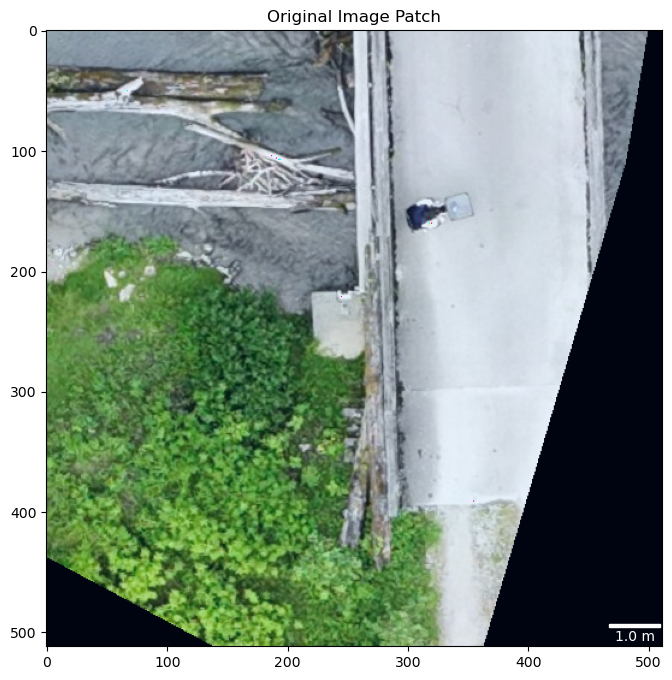

In [15]:
# Test one preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 200 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"
test_patch_path = patches_dir + f"/" + test_patch_name

# load npz-file
test_patch = np.load(test_patch_path)

  # Show characteristics of the patch
print("Shape of the patches:", test_patch.shape)
print("Datatype:", test_patch.dtype)
print("Type:", type(test_patch))
print("Mean:", np.mean(test_patch))
print("Minimum value:", np.min(test_patch))
print("Maximum value:", np.max(test_patch))

# import the norm_plot_patch function for normalization and plotting of the test patch
visualization_utils.norm_plot_patch(test_patch, test_patch_name)

3. Masks

In [16]:
# list of all masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
print(masks_list[0:3])
len(masks_list)

['A01_patch_180_mask.npy', 'A01_patch_0_mask.npy', 'A01_patch_138_mask.npy']


3836

In [17]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 200 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_name = f"{SECTION}_patch_{TEST_MASK_ID}_mask.npy"
test_mask_path = masks_dir + f"/" + test_mask_name

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask), "\n") # binary mask



Shape of the mask: (5, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1] 



Plot the mask

A06_patch_200_mask.npy


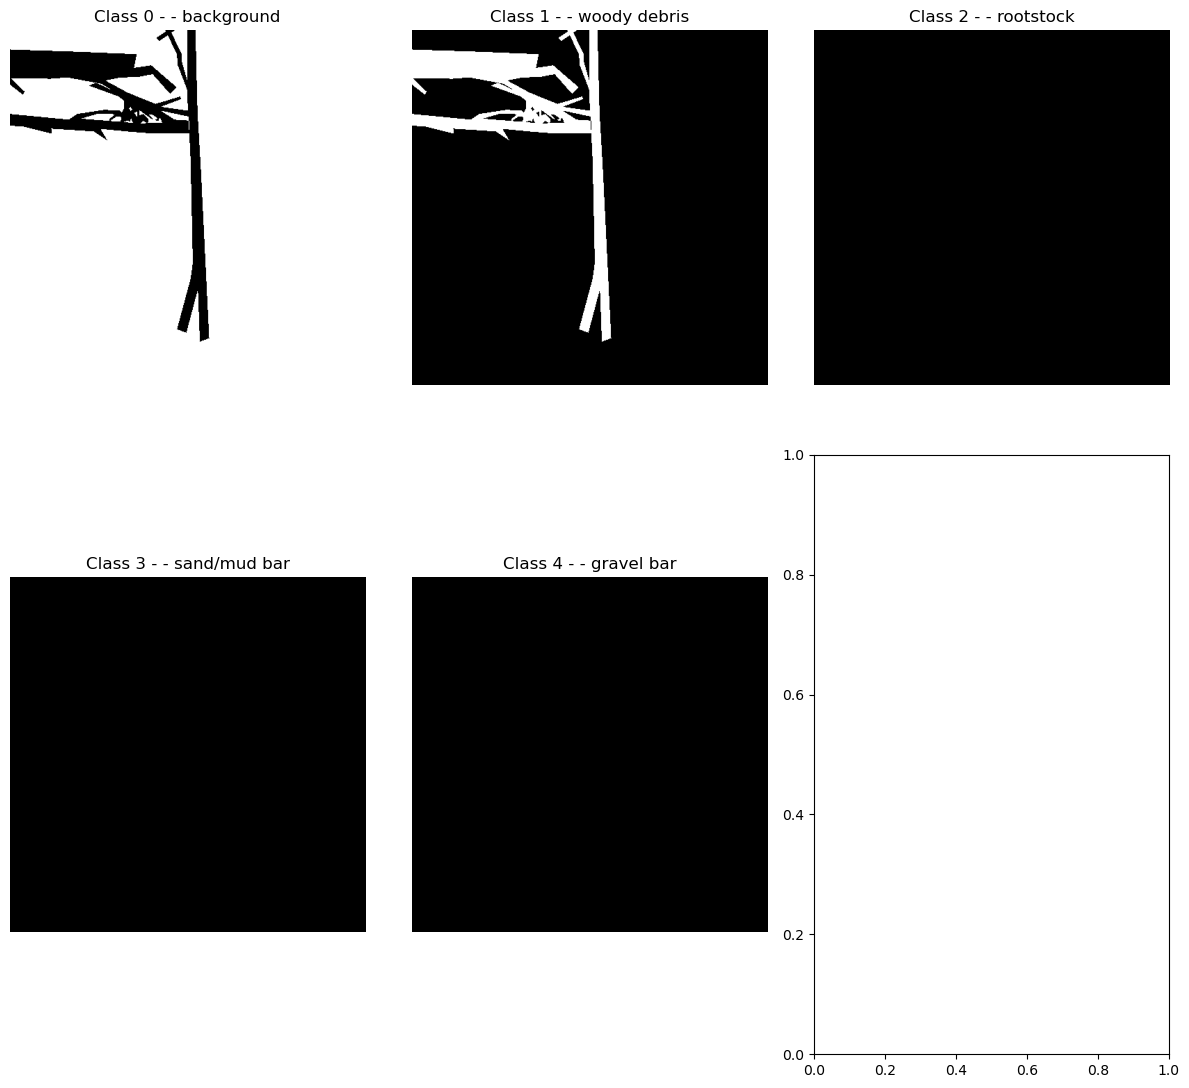

In [18]:
# ONE-HOT-ENCODED
print(test_mask_name)
fig, axes = plt.subplots(2, 3, figsize=(12, 12))  # 2x3 grid (for 5 classes)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_codes[i]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

A06_patch_200_mask.npy


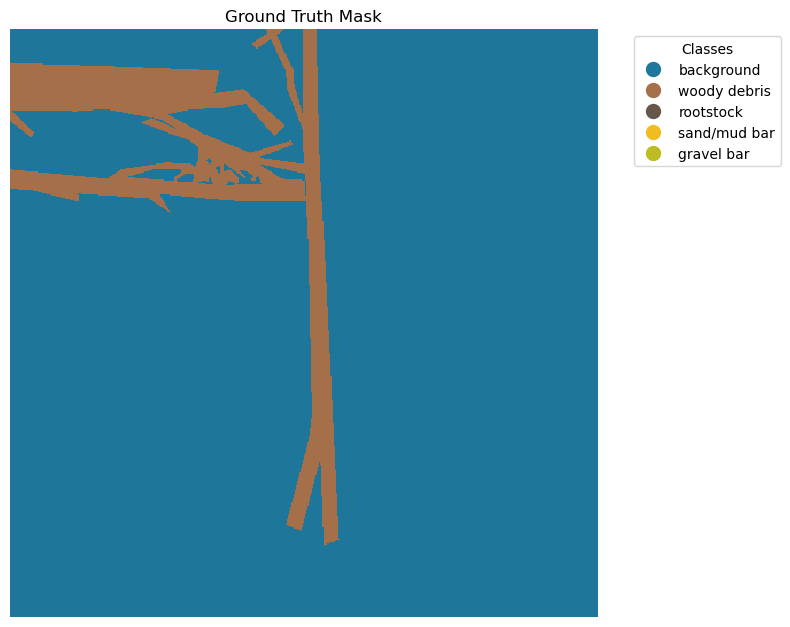

In [19]:
# alternative way of plotting the masks - not in one-hot-encoded, but in class-index-format
# CLASS-INDEX-FORMAT

# convert into class-index format
test_mask_idxformat = np.argmax(test_mask, axis=0)

visualization_utils.plot_mask_idxformat(test_mask_idxformat, test_mask_name, reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"])

## 2. Splitting data into train and test datasets

In [20]:
# extract section and patch_id from masks and patches (utils function)
print(data_utils.extract_section_and_id(masks_list[2]))
print(data_utils.extract_section_and_id(patches_list[175]))

('A01', '138')
('A01', '255')


In [21]:
# group patches by section
################################################################################

section_patches = {} # empty dictionary
for patch in patches_list: # iterate over all preprocessed patches
    section, patch_id = data_utils.extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

print(section_patches.keys())
# print(section_patches)

dict_keys(['A01', 'A02', 'A04', 'A06', 'A03', 'A05', 'A07', 'A08'])


In [22]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in configs_sc.HYPERPARAMETERS["train_sections"]: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in configs_sc.HYPERPARAMETERS["test_sections"]:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")
print(f"Testdata-Ratio: {100*(len(test_data)/len(train_data))}")
print(f"Traindata-Ratio: {100 - 100*(len(test_data)/len(train_data))}")

Training Patches: 3077
Test Patches: 759
Testdata-Ratio: 24.666883327916803
Traindata-Ratio: 75.3331166720832


In [23]:
# Show random patch name in training data
print(train_data[8])

# test if this random patch has a corresponding mask
data_utils.has_mask(train_data[8], masks_dir)

A01_patch_146.npy


True

In [24]:
# Separate training and test patches 
################################################################################

train_data = [f for f in train_data if data_utils.has_mask(f, masks_dir)]
test_data = [f for f in test_data if data_utils.has_mask(f, masks_dir)]

print(f"Training data- Number of patches: {len(train_data)}")
print(f"Test data - Number of patches: {len(test_data)}")

Training data- Number of patches: 3077
Test data - Number of patches: 759


## 3. Data augmentation, Dataset and DataLoader

### 3.1 Data augmentation

In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define training transformations with augmentation using Albumentations
train_transforms = A.Compose([
    
    # horizontal flip with a probability of 0.5
    A.HorizontalFlip(p=0.5),
    # vertical flip 
    A.VerticalFlip(p=0.5), 
    # randomly rotate the image by 90 degrees 
    A.RandomRotate90(p=0.5), 
    # random adjustments to brightness, contrast, saturation, and hue
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), 
    # affine transformation:
    # #### A.Affine(rotate=(-90, 90), translate_percent=(-0.1, 0.1), scale=(0.9, 1.1), p=0.5),
    # - rotate: randomly rotate within the range (-90, 90) degrees
    # - translate_percent: randomly translate by up to ±10% of image dimensions
    # - scale: randomly scale the image between 0.9 and 1.1 times its original size
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask


# Define test transformations without augmentation (only normalization and conversion to tensor)
test_transforms = A.Compose([
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask

/home/sc.uni-leipzig.de/rf37uqip/.local/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 3.2 Dataset

In [26]:
# with Data augmentation
################################
# Apply Datasets and check properties
################################################################################

# Train dataset
train_dataset = data_utils.PatchDatasetCplx(train_data, patches_dir, masks_dir, transform = train_transforms)

# check properties of the train dataset:
print("Train dataset:\n")
print("Type of dataset:", type(train_dataset))
print("Number of patches:", len(train_dataset))
print("Random patch:", train_dataset[0][0])
print("Patch shape:", train_dataset[0][1].shape)
print("Mask shape:", train_dataset[0][2].shape, "\n")

# Test datasets
test_dataset = data_utils.PatchDatasetCplx(test_data, patches_dir, masks_dir, transform = test_transforms) 

# check properties of the test dataset:
print("Test dataset:\n")
print("Type of dataset:", type(test_dataset))
print("Number of patches:", len(test_dataset))
print("Random patch:", test_dataset[0][0])
print("Patch shape:", test_dataset[0][1].shape)
print("Mask shape:", test_dataset[0][2].shape, "\n")

Train dataset:

Type of dataset: <class 'scripts.data_utils.PatchDatasetCplx'>
Number of patches: 3077
Random patch: A01_patch_142.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 

Test dataset:

Type of dataset: <class 'scripts.data_utils.PatchDatasetCplx'>
Number of patches: 759
Random patch: A04_patch_30.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 



In [26]:
# # without Data augmentation
# ###############################
# # Apply Datasets and check properties
# ################################################################################

# # Train dataset
# train_dataset = data_utils.PatchDatasetSimple(train_data, patches_dir, masks_dir)

# # check properties of the train dataset:
# print("Train dataset:\n")
# print("Type of dataset:", type(train_dataset))
# print("Number of patches:", len(train_dataset))
# print("Random patch:", train_dataset[0][0])
# print("Patch shape:", train_dataset[0][1].shape)
# print("Mask shape:", train_dataset[0][2].shape, "\n")

# # Simple Test dataset
# test_dataset = data_utils.PatchDatasetSimple(test_data, patches_dir, masks_dir) 

# # check properties of the test dataset:
# print("Test dataset:\n")
# print("Type of dataset:", type(test_dataset))
# print("Number of patches:", len(test_dataset))
# print("Random patch:", test_dataset[0][0])
# print("Patch shape:", test_dataset[0][1].shape)
# print("Mask shape:", test_dataset[0][2].shape, "\n")

### 3.3 DataLoader

Right now the data is in the form of Pytorch Datasets (see above). The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or simply `DataLoader`.

The `DataLoader`
- helps load data into the model.
- for training and for inference.
- **turns a large `Dataset` into a Python iterable** of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

In [27]:
from torch.utils.data import DataLoader

BATCH_SIZE = configs_sc.HYPERPARAMETERS["batch_size"]

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataloader:", train_loader)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
# test_loader_simple = DataLoader(test_dataset_simple, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Check dataloader
print(f"Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
print(f"Test Batches: {len(test_loader)}", f"= up to {len(test_loader)*BATCH_SIZE} patches")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x15373befc170>
Training Batches: 385 = up to 3080 patches
Test Batches: 95 = up to 760 patches


### 3.4 Data exploration and class weights

In [28]:
# # Explore one batch of data in train_loader
# for batch_idx, (names, images, masks) in enumerate(train_loader):
#     print(f"Batch {batch_idx + 1}:", "\n------------\n------------")
#     print(f"Names - first patch name of the batch: {names[0]}", "\n------------")
#     print(f"Image type: {type(images)}")
#     print(f"Images shape: {images.shape}")  # Should be [batch_size, channels, height, width]
#     print(f"Image excerpt of the first patch: {images[0,:,:4,:4]}")
#     print(f"Images dtype: {images.dtype}", "\n------------")
#     print(f"Masks shape: {masks.shape}")    # Should be [batch_size, channels, height, width]
#     print(f"Mask excerpt of the mask of the fourth patch: {masks[0,:,:2,:2]}")
#     print(f"Masks dtype: {masks.dtype}")
#     break # break after first batch (batch 1)

In [29]:
# # TRAIN LOADER
# # Show pixel distribution per class in train_loader
# pixel_distribution_train = data_utils.pixel_distribution_dataloader(
#     data_loader=train_loader,
#     num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
#     device=device
# )

# # Visualize results
# plt.bar(pixel_distribution_train.keys(), pixel_distribution_train.values())
# plt.xlabel("Class")
# plt.ylabel("Percentage of Pixels (%)")
# plt.title("Pixel Distribution Across Classes (Train Dataset)")
# plt.xticks()
# plt.show()

In [30]:
# # TEST LOADER
# # Show pixel distribution per class in test_loader
# pixel_distribution_test = data_utils.pixel_distribution_dataloader(
#     data_loader=test_loader,
#     num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
#     device=device
# )

# # Visualize results
# plt.bar(pixel_distribution_test.keys(), pixel_distribution_test.values())
# plt.xlabel("Class")
# plt.ylabel("Percentage of Pixels (%)")
# plt.title("Pixel Distribution Across Classes (Test Dataset)")
# plt.xticks()
# plt.show()

In [28]:
# pixel_dist_train = torch.tensor(list(pixel_distribution_train.values()), dtype=torch.float32, device=device)
pixel_dist_train = torch.tensor([98.5564,  1.4437], dtype=torch.float32, device=device)
print("Pixel distribution in train dataset:", pixel_dist_train)

Pixel distribution in train dataset: tensor([98.5564,  1.4437], device='cuda:0')


In [29]:
# calculate the (inverse proportional) weights to outweigh the class imbalances
class_weights = 1/ (pixel_dist_train/100)
print("Class weights:", class_weights)

normalized_weights = class_weights / class_weights.sum()
print("Normalized weights:", normalized_weights)

Class weights: tensor([ 1.0146, 69.2665], device='cuda:0')
Normalized weights: tensor([0.0144, 0.9856], device='cuda:0')


To take into account the class imbalances in this dataset, we adjust the weight parameters in the CrossEntropyLoss function accordingly. Based on the pixel distribution, the weights can be set as follows:

| Class | Average pixel distribution (%) | Normalized Weight |
| ----- | ----- | ----- |
| 0 | 98.5564 | 0.0144 |
| 1 | 1.4437   | 0.9856 |


(
| 2 | 0.1185 | 0.5546 |
| 3 | 0.2076 | 0.3164 |
| 4 | 0.7930 | 0.0829 |
)

## 4. Segmentation model

U-Net is a fully convolution neural network for image semantic segmentation. Consist of encoder and decoder parts connected with skip connections. Encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation mask. 

URL: https://smp.readthedocs.io/en/latest/models.html#unet

In [30]:
################################################################################
# model_0 = smp.Unet(   # -------------------->> ADJUSTABLE
#     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (3 for RGB)
#     classes=configs_sc.HYPERPARAMETERS["num_classes"],       # model output channels (number of classes)
# )
################################################################################

In [55]:
# train already trained model
model = loaded_model
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [56]:
# model = model_utils.model_0.to(device)

In [57]:
# show model costruction
# model.to(device)

In [58]:
# show (hidden) layers of the model
# model.state_dict().keys()

In [59]:
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Setup loss, optimizer and evaluation metrics

Setup loss function and optimizer

In [60]:
# Setup loss function
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weight = normalized_weights).to(device)

In [61]:
# Setup optimizer
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), configs_sc.HYPERPARAMETERS["learning_rate"], betas=(0.9, 0.999))

# AdamW = Adam with weight decay
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=configs_sc.HYPERPARAMETERS["learning_rate"],  # learning rate
    weight_decay=1e-4  # regularisation
)

Evaluation metrics

In [62]:
accuracy_fn = evaluation_utils.oa_accuracy_fn

### 4.2 Training and test loop

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.

Learning rate: 1e-06
Number of epochs: 50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss of [Batch 0/385]: 0.2522
Train Loss of [Batch 100/385]: 0.2811
Train Loss of [Batch 200/385]: 0.2450
Train Loss of [Batch 300/385]: 0.2862

Train loss: 0.30591 | Train accuracy: 91.13%
Train Class-wise Loss: tensor([0.2994, 0.3168], device='cuda:0')

Test loss: 0.25302 | Test accuracy: 86.24%
Test Class-wise Loss: tensor([0.4014, 0.2478], device='cuda:0')



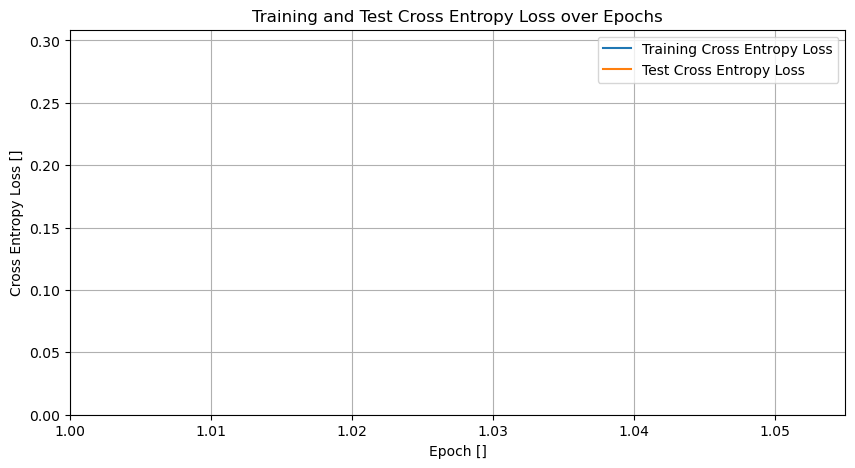

Epoch: 1
---------
Train Loss of [Batch 0/385]: 0.3485
Train Loss of [Batch 100/385]: 0.3056
Train Loss of [Batch 200/385]: 0.2913
Train Loss of [Batch 300/385]: 0.4575

Train loss: 0.30419 | Train accuracy: 91.12%
Train Class-wise Loss: tensor([0.2989, 0.3163], device='cuda:0')

Test loss: 0.25037 | Test accuracy: 87.81%
Test Class-wise Loss: tensor([0.3616, 0.2818], device='cuda:0')



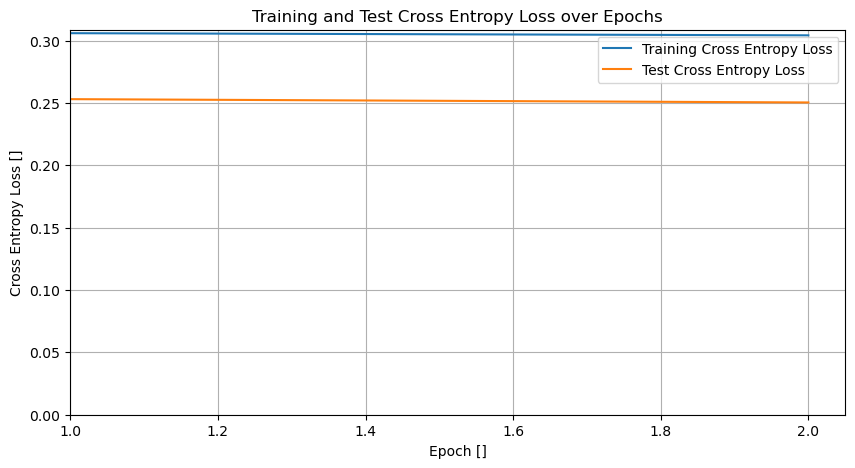

Epoch: 2
---------
Train Loss of [Batch 0/385]: 0.3265
Train Loss of [Batch 100/385]: 0.2185
Train Loss of [Batch 200/385]: 0.2271
Train Loss of [Batch 300/385]: 0.2760

Train loss: 0.30275 | Train accuracy: 91.07%
Train Class-wise Loss: tensor([0.2981, 0.3196], device='cuda:0')

Test loss: 0.25054 | Test accuracy: 88.47%
Test Class-wise Loss: tensor([0.3415, 0.2957], device='cuda:0')



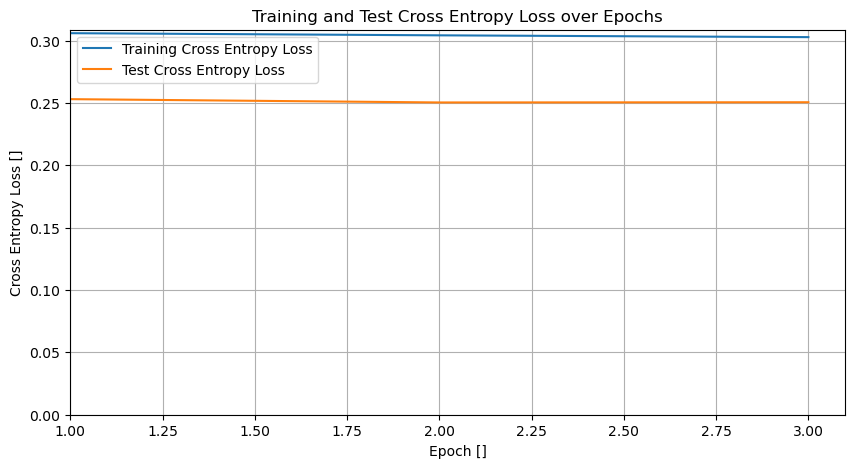

Epoch: 3
---------
Train Loss of [Batch 0/385]: 0.2730
Train Loss of [Batch 100/385]: 0.2793
Train Loss of [Batch 200/385]: 0.2395
Train Loss of [Batch 300/385]: 0.4011

Train loss: 0.30177 | Train accuracy: 91.14%
Train Class-wise Loss: tensor([0.2959, 0.3216], device='cuda:0')

Test loss: 0.24885 | Test accuracy: 87.53%
Test Class-wise Loss: tensor([0.3634, 0.2710], device='cuda:0')



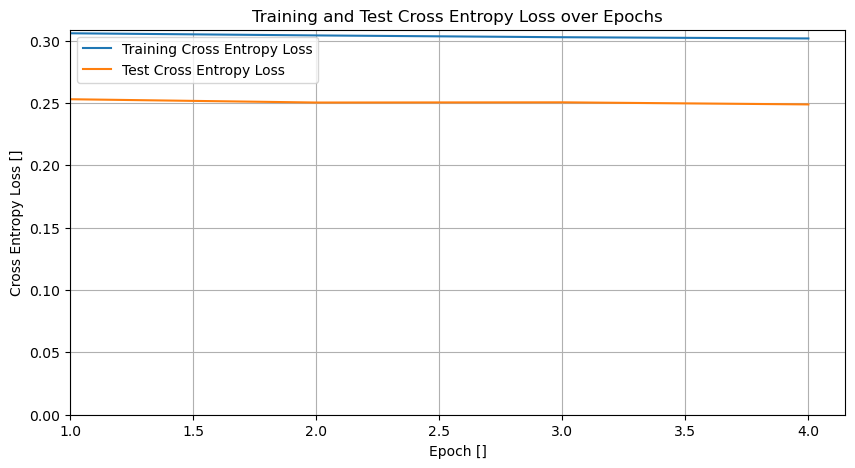

Epoch: 4
---------
Train Loss of [Batch 0/385]: 0.3803
Train Loss of [Batch 100/385]: 0.2993
Train Loss of [Batch 200/385]: 0.2195
Train Loss of [Batch 300/385]: 0.2546

Train loss: 0.29986 | Train accuracy: 91.18%
Train Class-wise Loss: tensor([0.2929, 0.3085], device='cuda:0')

Test loss: 0.24899 | Test accuracy: 88.81%
Test Class-wise Loss: tensor([0.3296, 0.3055], device='cuda:0')



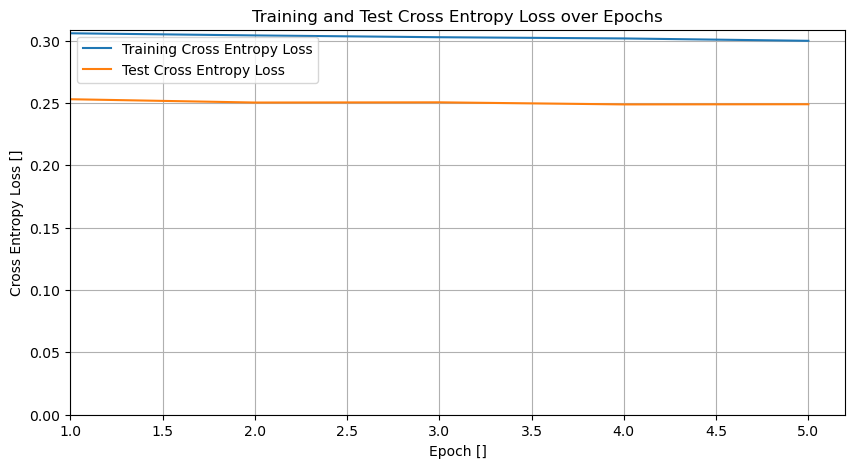

Epoch: 5
---------
Train Loss of [Batch 0/385]: 0.2305
Train Loss of [Batch 100/385]: 0.4558
Train Loss of [Batch 200/385]: 0.3053
Train Loss of [Batch 300/385]: 0.4976

Train loss: 0.29867 | Train accuracy: 91.09%
Train Class-wise Loss: tensor([0.2943, 0.3100], device='cuda:0')

Test loss: 0.24718 | Test accuracy: 88.83%
Test Class-wise Loss: tensor([0.3290, 0.3064], device='cuda:0')



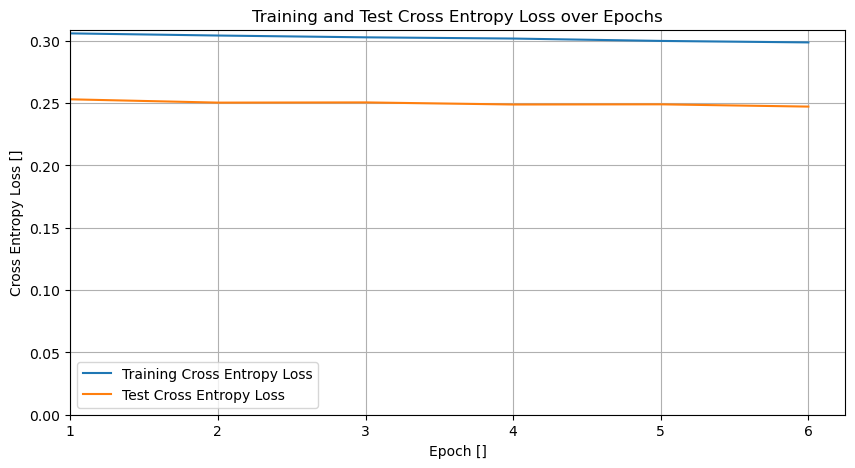

Epoch: 6
---------
Train Loss of [Batch 0/385]: 0.3343
Train Loss of [Batch 100/385]: 0.2559
Train Loss of [Batch 200/385]: 0.2716
Train Loss of [Batch 300/385]: 0.2656

Train loss: 0.29798 | Train accuracy: 91.26%
Train Class-wise Loss: tensor([0.2903, 0.3163], device='cuda:0')

Test loss: 0.24480 | Test accuracy: 88.42%
Test Class-wise Loss: tensor([0.3427, 0.2888], device='cuda:0')



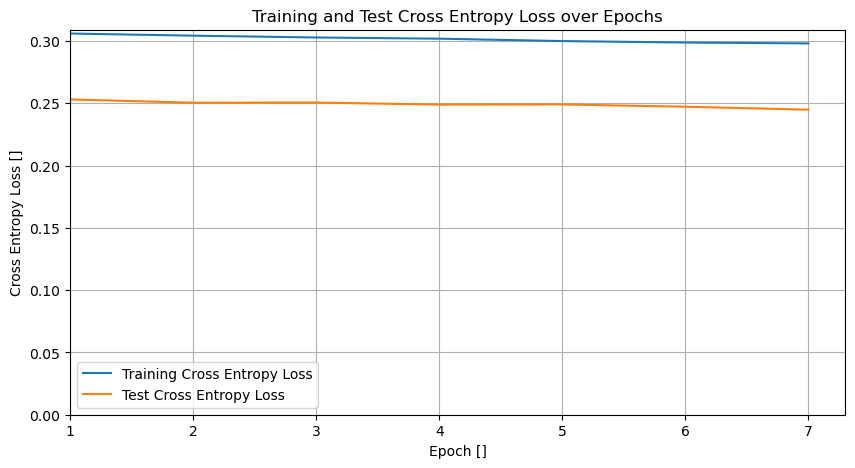

Epoch: 7
---------
Train Loss of [Batch 0/385]: 0.2410
Train Loss of [Batch 100/385]: 0.3134
Train Loss of [Batch 200/385]: 0.2952
Train Loss of [Batch 300/385]: 0.3372

Train loss: 0.29784 | Train accuracy: 91.20%
Train Class-wise Loss: tensor([0.2904, 0.3286], device='cuda:0')

Test loss: 0.24556 | Test accuracy: 87.79%
Test Class-wise Loss: tensor([0.3529, 0.2748], device='cuda:0')



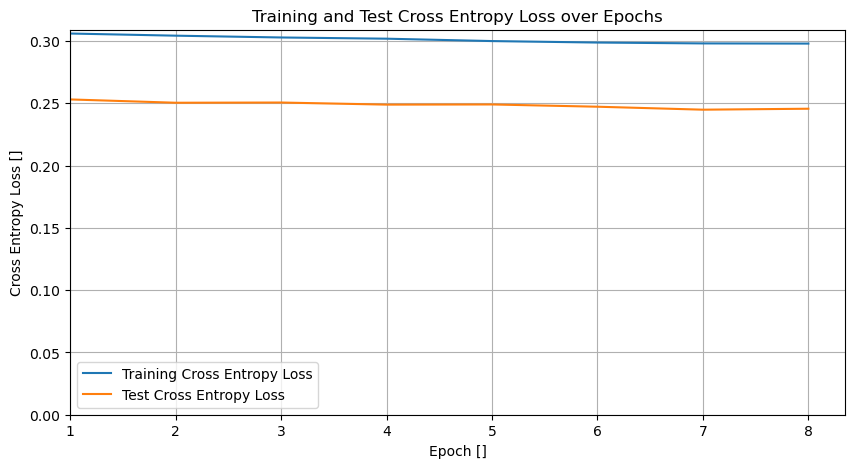

Epoch: 8
---------
Train Loss of [Batch 0/385]: 0.4377
Train Loss of [Batch 100/385]: 0.3320
Train Loss of [Batch 200/385]: 0.2722
Train Loss of [Batch 300/385]: 0.1775

Train loss: 0.29547 | Train accuracy: 91.22%
Train Class-wise Loss: tensor([0.2884, 0.3216], device='cuda:0')

Test loss: 0.24632 | Test accuracy: 86.29%
Test Class-wise Loss: tensor([0.3933, 0.2515], device='cuda:0')



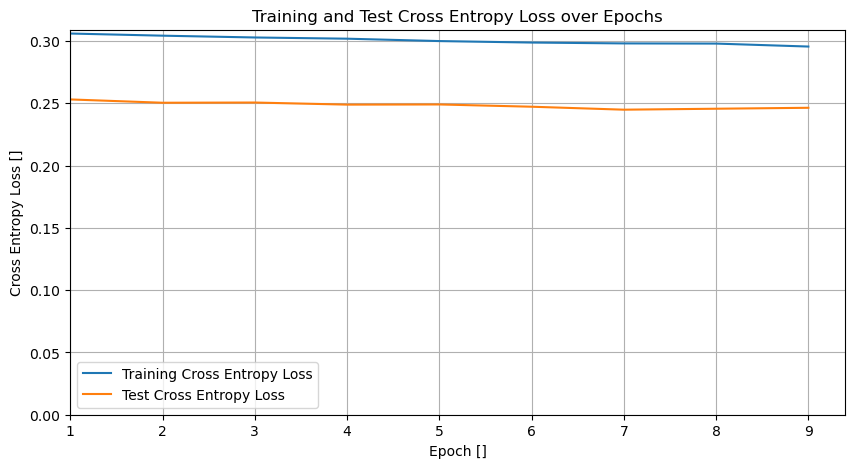

Epoch: 9
---------
Train Loss of [Batch 0/385]: 0.2967
Train Loss of [Batch 100/385]: 0.2122
Train Loss of [Batch 200/385]: 0.2414
Train Loss of [Batch 300/385]: 0.2650

Train loss: 0.29171 | Train accuracy: 91.26%
Train Class-wise Loss: tensor([0.2860, 0.3049], device='cuda:0')

Test loss: 0.24692 | Test accuracy: 85.98%
Test Class-wise Loss: tensor([0.4011, 0.2422], device='cuda:0')



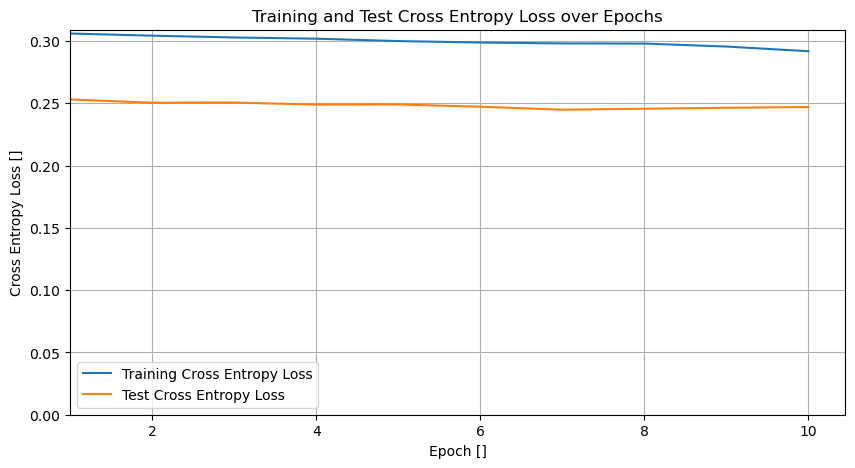

Epoch: 10
---------
Train Loss of [Batch 0/385]: 0.2540
Train Loss of [Batch 100/385]: 0.4014
Train Loss of [Batch 200/385]: 0.3060
Train Loss of [Batch 300/385]: 0.3344

Train loss: 0.28890 | Train accuracy: 91.25%
Train Class-wise Loss: tensor([0.2855, 0.3046], device='cuda:0')

Test loss: 0.24386 | Test accuracy: 87.50%
Test Class-wise Loss: tensor([0.3615, 0.2719], device='cuda:0')



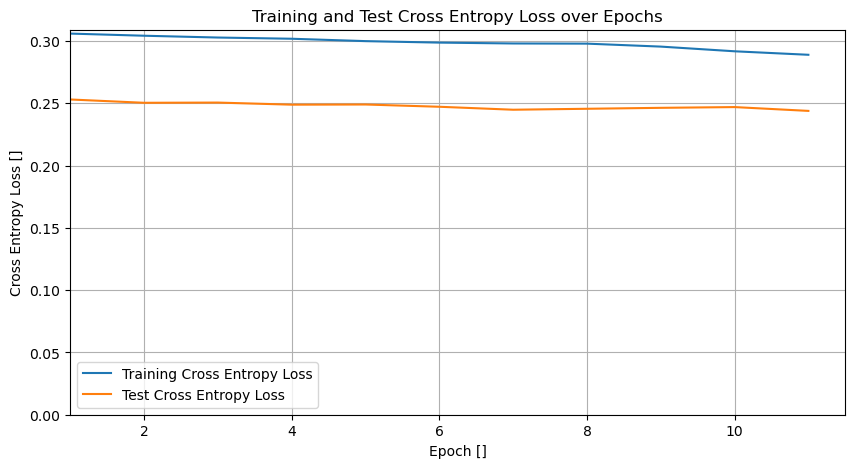

Epoch: 11
---------
Train Loss of [Batch 0/385]: 0.3212
Train Loss of [Batch 100/385]: 0.2481
Train Loss of [Batch 200/385]: 0.2879
Train Loss of [Batch 300/385]: 0.2727

Train loss: 0.28791 | Train accuracy: 91.35%
Train Class-wise Loss: tensor([0.2824, 0.3080], device='cuda:0')

Test loss: 0.24425 | Test accuracy: 88.57%
Test Class-wise Loss: tensor([0.3331, 0.2999], device='cuda:0')



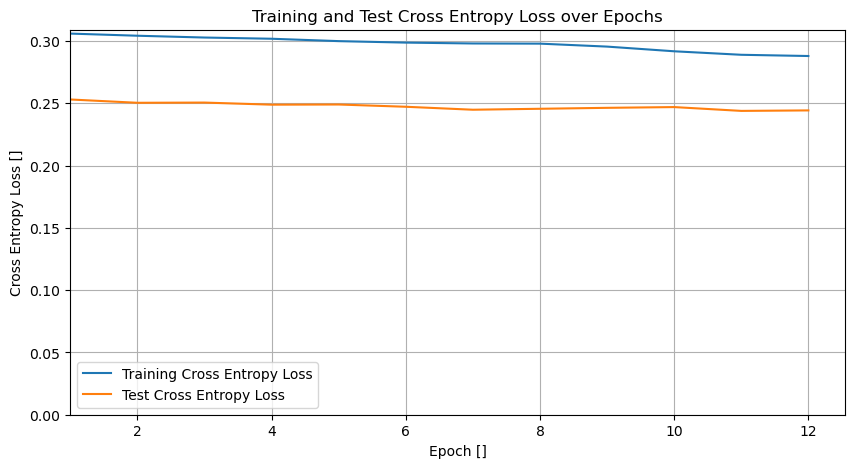

Epoch: 12
---------
Train Loss of [Batch 0/385]: 0.2761
Train Loss of [Batch 100/385]: 0.2922
Train Loss of [Batch 200/385]: 0.5098
Train Loss of [Batch 300/385]: 0.4476

Train loss: 0.28973 | Train accuracy: 91.21%
Train Class-wise Loss: tensor([0.2851, 0.3026], device='cuda:0')

Test loss: 0.24619 | Test accuracy: 87.14%
Test Class-wise Loss: tensor([0.3686, 0.2646], device='cuda:0')



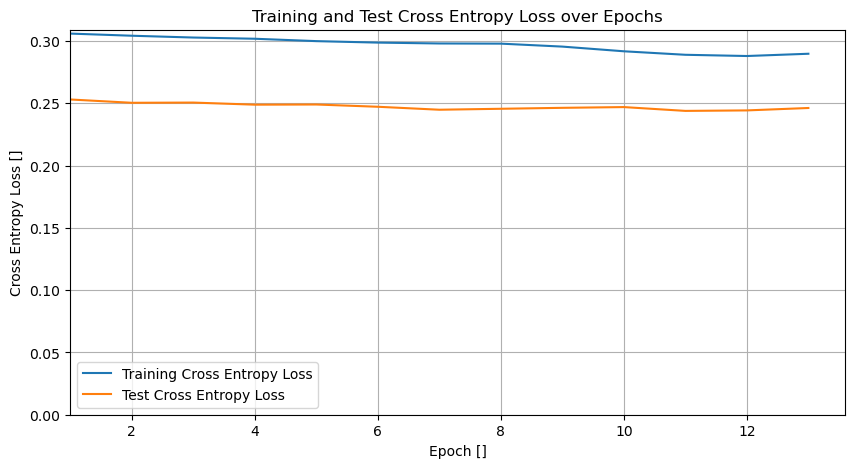

Epoch: 13
---------
Train Loss of [Batch 0/385]: 0.2713
Train Loss of [Batch 100/385]: 0.2644
Train Loss of [Batch 200/385]: 0.2758
Train Loss of [Batch 300/385]: 0.2208

Train loss: 0.28715 | Train accuracy: 91.50%
Train Class-wise Loss: tensor([0.2779, 0.3061], device='cuda:0')

Test loss: 0.24361 | Test accuracy: 88.56%
Test Class-wise Loss: tensor([0.3345, 0.2955], device='cuda:0')



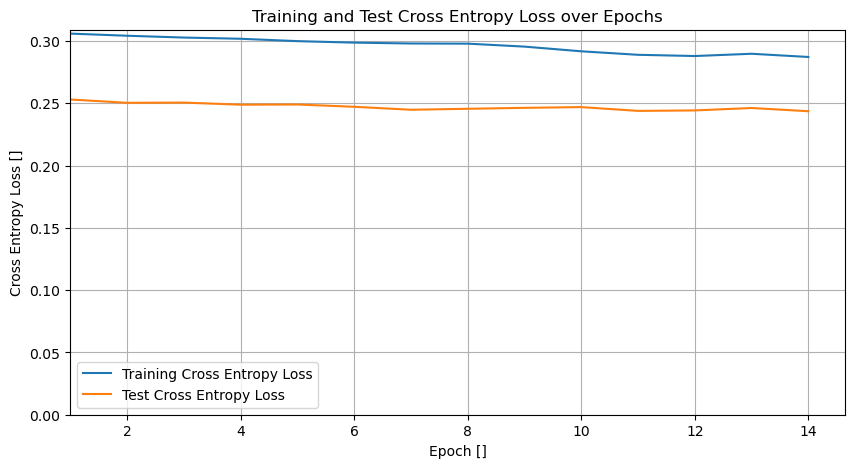

Epoch: 14
---------
Train Loss of [Batch 0/385]: 0.3653
Train Loss of [Batch 100/385]: 0.3645
Train Loss of [Batch 200/385]: 0.2607
Train Loss of [Batch 300/385]: 0.2975

Train loss: 0.28613 | Train accuracy: 91.27%
Train Class-wise Loss: tensor([0.2804, 0.3009], device='cuda:0')

Test loss: 0.24321 | Test accuracy: 88.05%
Test Class-wise Loss: tensor([0.3429, 0.2815], device='cuda:0')



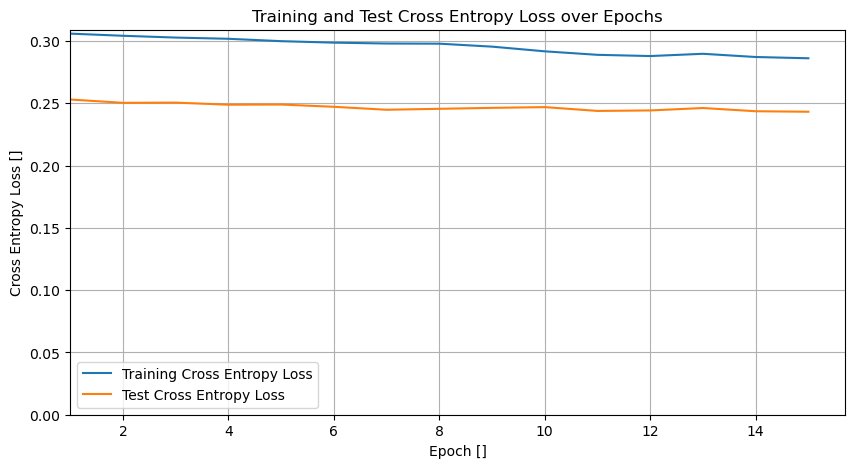

Epoch: 15
---------
Train Loss of [Batch 0/385]: 0.2808
Train Loss of [Batch 100/385]: 0.5072
Train Loss of [Batch 200/385]: 0.3029
Train Loss of [Batch 300/385]: 0.4109

Train loss: 0.28042 | Train accuracy: 91.51%
Train Class-wise Loss: tensor([0.2772, 0.2877], device='cuda:0')

Test loss: 0.24333 | Test accuracy: 87.10%
Test Class-wise Loss: tensor([0.3727, 0.2626], device='cuda:0')



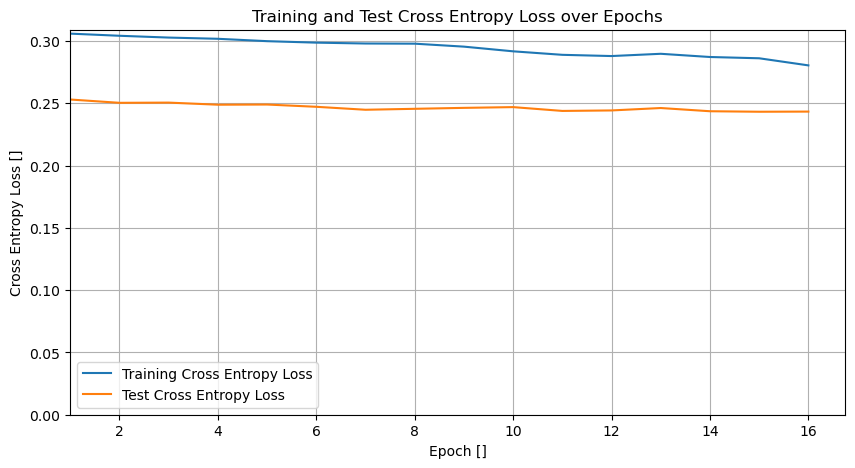

Epoch: 16
---------
Train Loss of [Batch 0/385]: 0.3320
Train Loss of [Batch 100/385]: 0.2420
Train Loss of [Batch 200/385]: 0.3085
Train Loss of [Batch 300/385]: 0.1834

Train loss: 0.28180 | Train accuracy: 91.50%
Train Class-wise Loss: tensor([0.2764, 0.2929], device='cuda:0')

Test loss: 0.24119 | Test accuracy: 87.77%
Test Class-wise Loss: tensor([0.3503, 0.2768], device='cuda:0')



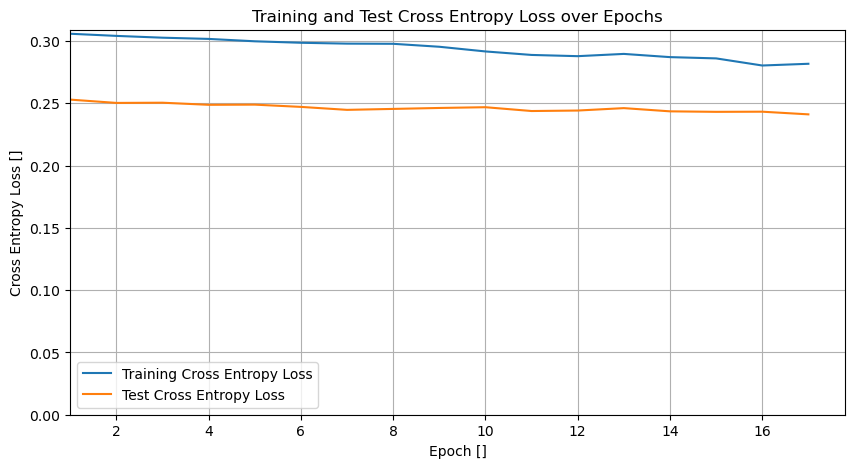

Epoch: 17
---------
Train Loss of [Batch 0/385]: 0.2750
Train Loss of [Batch 100/385]: 0.2206
Train Loss of [Batch 200/385]: 0.2163
Train Loss of [Batch 300/385]: 0.2987

Train loss: 0.28046 | Train accuracy: 91.56%
Train Class-wise Loss: tensor([0.2731, 0.3031], device='cuda:0')

Test loss: 0.24093 | Test accuracy: 87.34%
Test Class-wise Loss: tensor([0.3641, 0.2664], device='cuda:0')



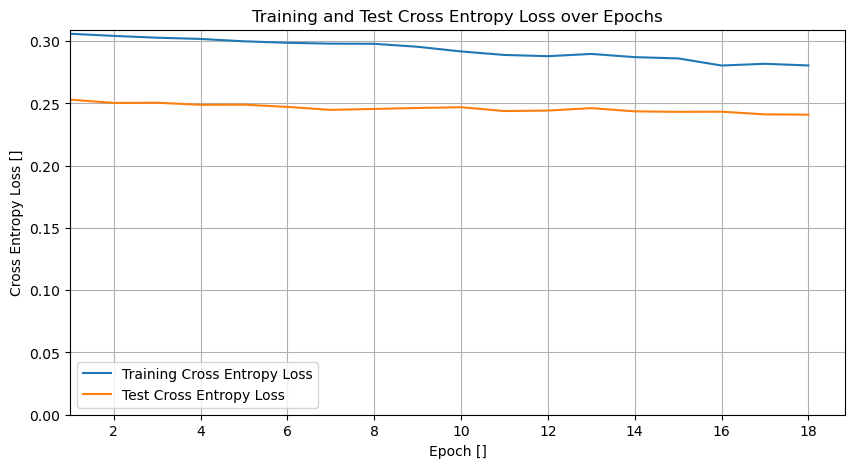

Epoch: 18
---------
Train Loss of [Batch 0/385]: 0.2095
Train Loss of [Batch 100/385]: 0.2052
Train Loss of [Batch 200/385]: 0.2293
Train Loss of [Batch 300/385]: 0.3344

Train loss: 0.28103 | Train accuracy: 91.60%
Train Class-wise Loss: tensor([0.2708, 0.3015], device='cuda:0')

Test loss: 0.24315 | Test accuracy: 89.41%
Test Class-wise Loss: tensor([0.3108, 0.3184], device='cuda:0')



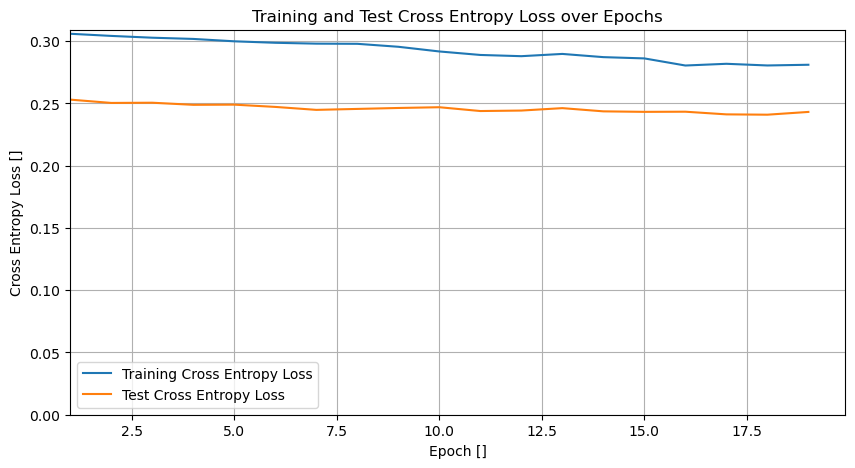

Epoch: 19
---------
Train Loss of [Batch 0/385]: 0.3403
Train Loss of [Batch 100/385]: 0.2893
Train Loss of [Batch 200/385]: 0.2666
Train Loss of [Batch 300/385]: 0.3116

Train loss: 0.28226 | Train accuracy: 91.62%
Train Class-wise Loss: tensor([0.2712, 0.3149], device='cuda:0')

Test loss: 0.24180 | Test accuracy: 88.57%
Test Class-wise Loss: tensor([0.3288, 0.3021], device='cuda:0')



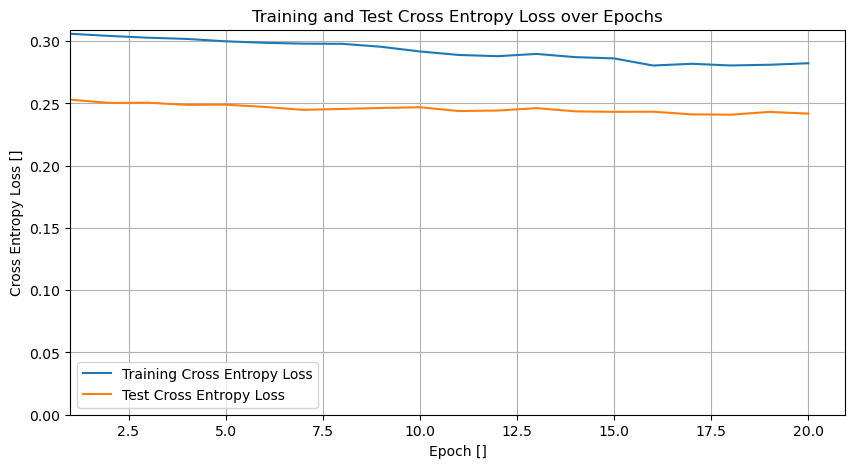

Epoch: 20
---------
Train Loss of [Batch 0/385]: 0.2441
Train Loss of [Batch 100/385]: 0.2328
Train Loss of [Batch 200/385]: 0.2373
Train Loss of [Batch 300/385]: 0.3793

Train loss: 0.27815 | Train accuracy: 91.55%
Train Class-wise Loss: tensor([0.2717, 0.2925], device='cuda:0')

Test loss: 0.23937 | Test accuracy: 87.95%
Test Class-wise Loss: tensor([0.3523, 0.2731], device='cuda:0')



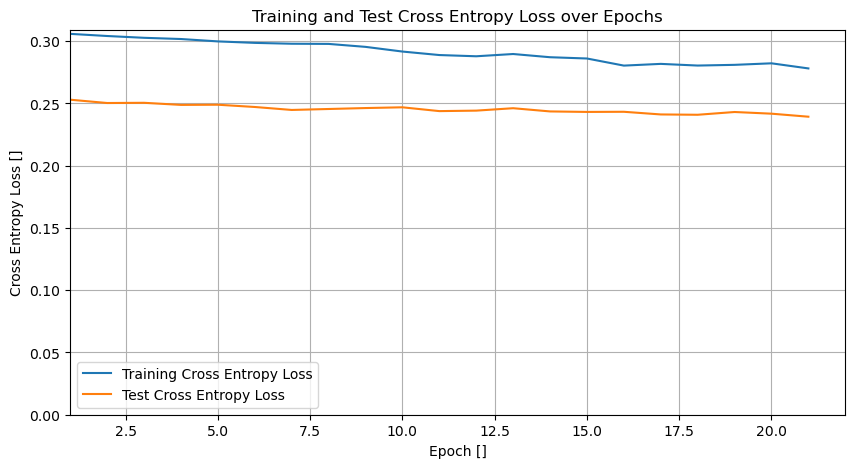

Epoch: 21
---------
Train Loss of [Batch 0/385]: 0.4890
Train Loss of [Batch 100/385]: 0.2736
Train Loss of [Batch 200/385]: 0.2978
Train Loss of [Batch 300/385]: 0.3556

Train loss: 0.28103 | Train accuracy: 91.66%
Train Class-wise Loss: tensor([0.2690, 0.3086], device='cuda:0')

Test loss: 0.23925 | Test accuracy: 88.66%
Test Class-wise Loss: tensor([0.3300, 0.3038], device='cuda:0')



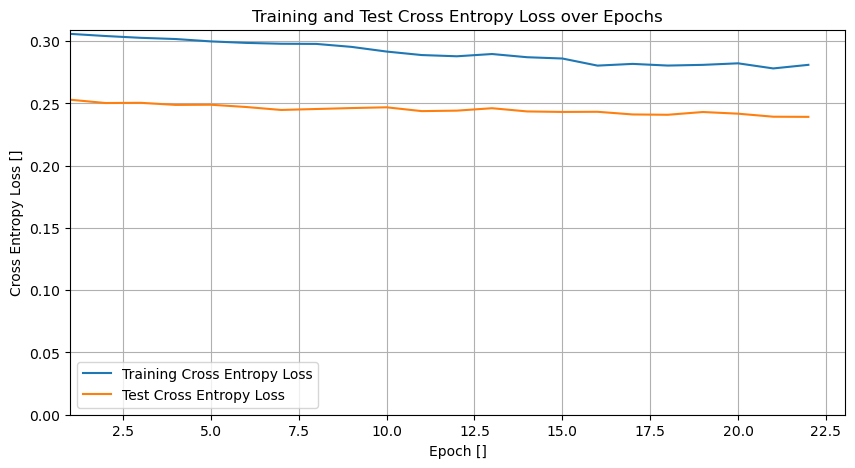

Epoch: 22
---------
Train Loss of [Batch 0/385]: 0.2223
Train Loss of [Batch 100/385]: 0.3094
Train Loss of [Batch 200/385]: 0.1608
Train Loss of [Batch 300/385]: 0.2692

Train loss: 0.27724 | Train accuracy: 91.70%
Train Class-wise Loss: tensor([0.2666, 0.2978], device='cuda:0')

Test loss: 0.23843 | Test accuracy: 88.66%
Test Class-wise Loss: tensor([0.3307, 0.2922], device='cuda:0')



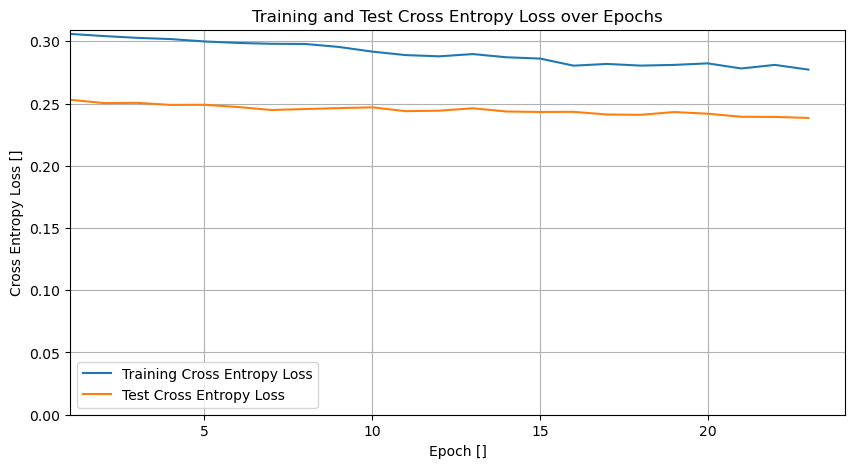

Epoch: 23
---------
Train Loss of [Batch 0/385]: 0.3699
Train Loss of [Batch 100/385]: 0.2760
Train Loss of [Batch 200/385]: 0.2672
Train Loss of [Batch 300/385]: 0.3303

Train loss: 0.27921 | Train accuracy: 91.67%
Train Class-wise Loss: tensor([0.2664, 0.3147], device='cuda:0')

Test loss: 0.23746 | Test accuracy: 87.65%
Test Class-wise Loss: tensor([0.3559, 0.2668], device='cuda:0')



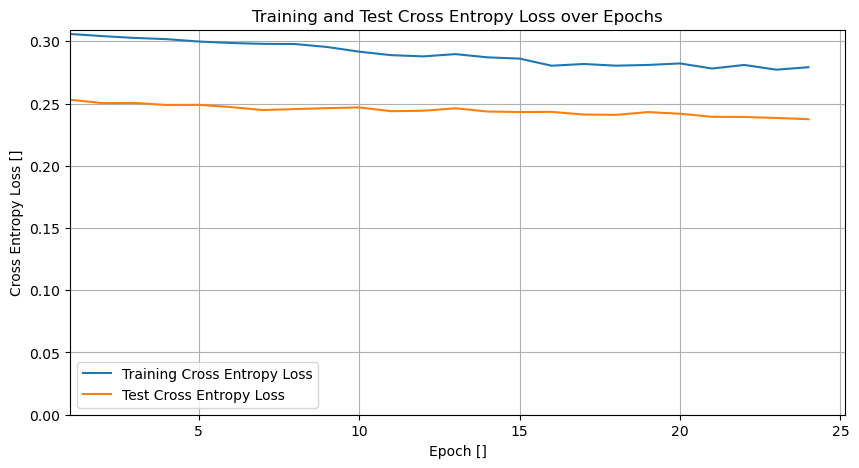

Epoch: 24
---------
Train Loss of [Batch 0/385]: 0.2366
Train Loss of [Batch 100/385]: 0.3028
Train Loss of [Batch 200/385]: 0.2596
Train Loss of [Batch 300/385]: 0.2636

Train loss: 0.27553 | Train accuracy: 91.76%
Train Class-wise Loss: tensor([0.2658, 0.2905], device='cuda:0')

Test loss: 0.23765 | Test accuracy: 88.28%
Test Class-wise Loss: tensor([0.3415, 0.2886], device='cuda:0')



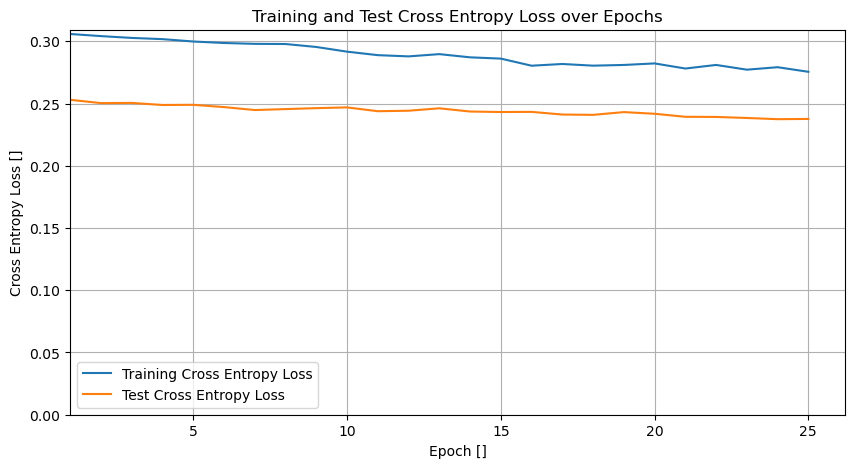

Epoch: 25
---------
Train Loss of [Batch 0/385]: 0.2879
Train Loss of [Batch 100/385]: 0.2444
Train Loss of [Batch 200/385]: 0.2133
Train Loss of [Batch 300/385]: 0.2124

Train loss: 0.27085 | Train accuracy: 91.64%
Train Class-wise Loss: tensor([0.2659, 0.2845], device='cuda:0')

Test loss: 0.23679 | Test accuracy: 88.91%
Test Class-wise Loss: tensor([0.3220, 0.2891], device='cuda:0')



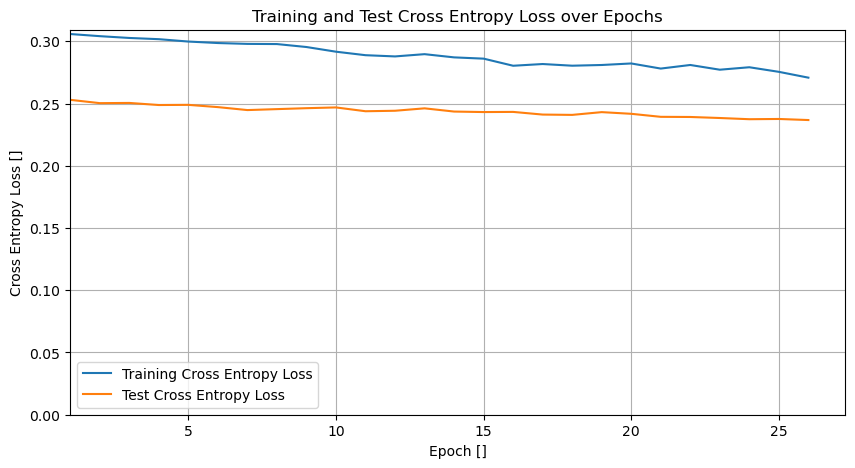

Epoch: 26
---------
Train Loss of [Batch 0/385]: 0.2098
Train Loss of [Batch 100/385]: 0.2658
Train Loss of [Batch 200/385]: 0.2153
Train Loss of [Batch 300/385]: 0.1835

Train loss: 0.27084 | Train accuracy: 91.74%
Train Class-wise Loss: tensor([0.2644, 0.2875], device='cuda:0')

Test loss: 0.23551 | Test accuracy: 88.23%
Test Class-wise Loss: tensor([0.3399, 0.2764], device='cuda:0')



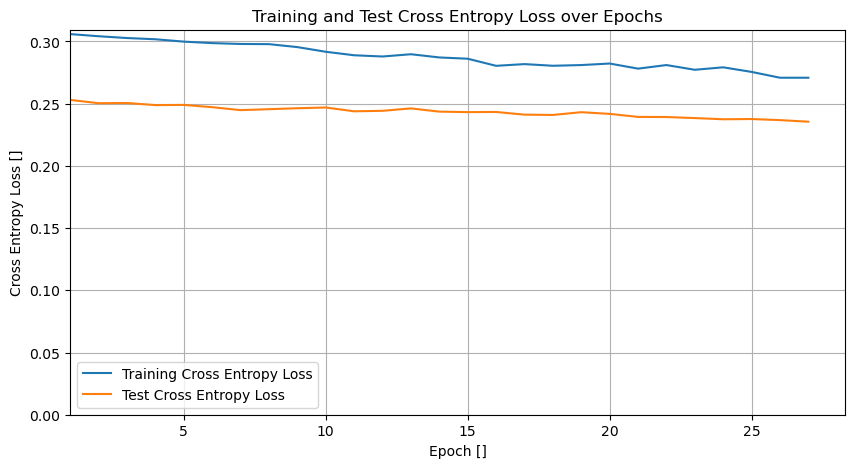

Epoch: 27
---------
Train Loss of [Batch 0/385]: 0.2901
Train Loss of [Batch 100/385]: 0.4204
Train Loss of [Batch 200/385]: 0.3140
Train Loss of [Batch 300/385]: 0.2676

Train loss: 0.27232 | Train accuracy: 91.75%
Train Class-wise Loss: tensor([0.2632, 0.2951], device='cuda:0')

Test loss: 0.23559 | Test accuracy: 88.51%
Test Class-wise Loss: tensor([0.3299, 0.2926], device='cuda:0')



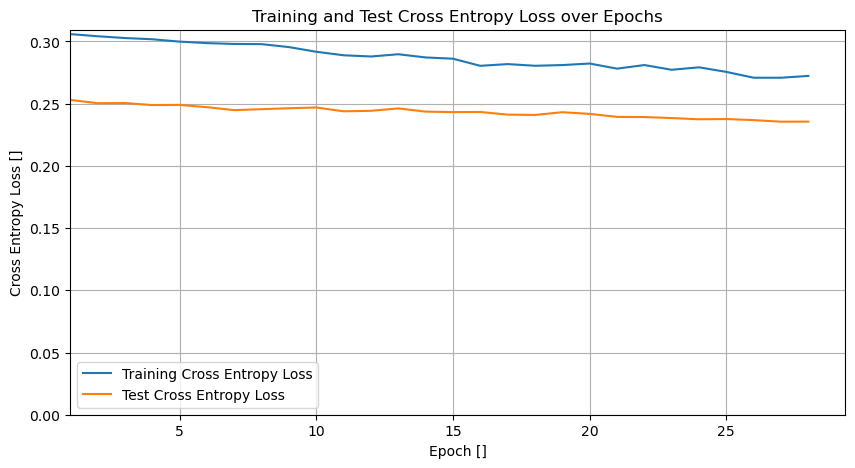

Epoch: 28
---------
Train Loss of [Batch 0/385]: 0.2725
Train Loss of [Batch 100/385]: 0.2024
Train Loss of [Batch 200/385]: 0.2920
Train Loss of [Batch 300/385]: 0.3098

Train loss: 0.27045 | Train accuracy: 91.97%
Train Class-wise Loss: tensor([0.2587, 0.2935], device='cuda:0')

Test loss: 0.23653 | Test accuracy: 89.79%
Test Class-wise Loss: tensor([0.3001, 0.3114], device='cuda:0')



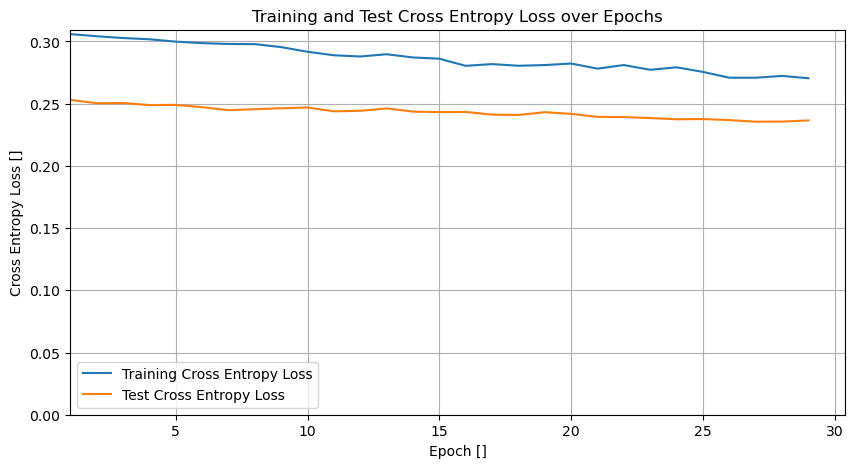

Epoch: 29
---------
Train Loss of [Batch 0/385]: 0.2449
Train Loss of [Batch 100/385]: 0.2313
Train Loss of [Batch 200/385]: 0.2146
Train Loss of [Batch 300/385]: 0.3060

Train loss: 0.26714 | Train accuracy: 91.97%
Train Class-wise Loss: tensor([0.2580, 0.2838], device='cuda:0')

Test loss: 0.23613 | Test accuracy: 88.85%
Test Class-wise Loss: tensor([0.3241, 0.2966], device='cuda:0')



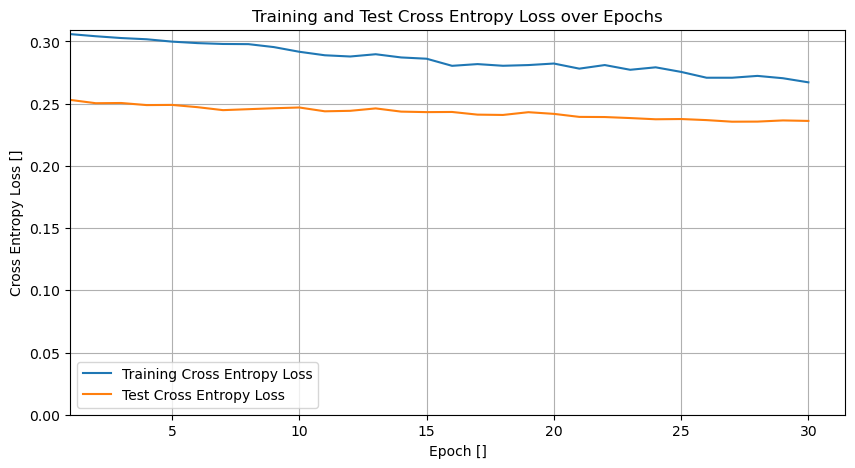

Epoch: 30
---------
Train Loss of [Batch 0/385]: 0.3012
Train Loss of [Batch 100/385]: 0.2234
Train Loss of [Batch 200/385]: 0.2451
Train Loss of [Batch 300/385]: 0.2907

Train loss: 0.26496 | Train accuracy: 91.91%
Train Class-wise Loss: tensor([0.2590, 0.2871], device='cuda:0')

Test loss: 0.23610 | Test accuracy: 89.45%
Test Class-wise Loss: tensor([0.3054, 0.3229], device='cuda:0')



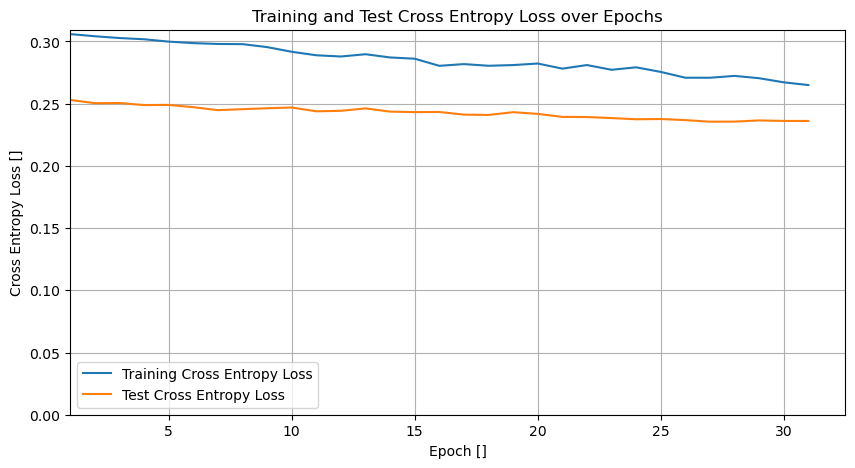

Epoch: 31
---------
Train Loss of [Batch 0/385]: 0.2825
Train Loss of [Batch 100/385]: 0.3852
Train Loss of [Batch 200/385]: 0.3112
Train Loss of [Batch 300/385]: 0.2154

Train loss: 0.26542 | Train accuracy: 91.77%
Train Class-wise Loss: tensor([0.2602, 0.2800], device='cuda:0')

Test loss: 0.23486 | Test accuracy: 89.17%
Test Class-wise Loss: tensor([0.3152, 0.2978], device='cuda:0')



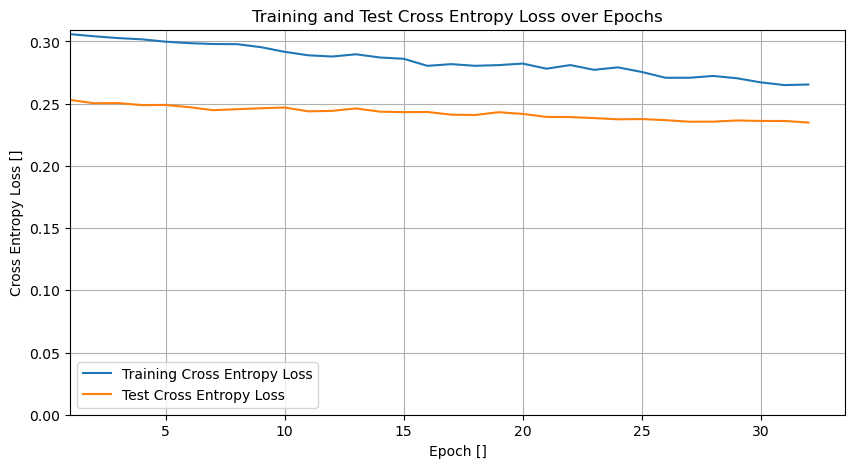

Epoch: 32
---------
Train Loss of [Batch 0/385]: 0.3007
Train Loss of [Batch 100/385]: 0.2417
Train Loss of [Batch 200/385]: 0.3519
Train Loss of [Batch 300/385]: 0.2258

Train loss: 0.26424 | Train accuracy: 91.97%
Train Class-wise Loss: tensor([0.2559, 0.2961], device='cuda:0')

Test loss: 0.23371 | Test accuracy: 88.44%
Test Class-wise Loss: tensor([0.3329, 0.2766], device='cuda:0')



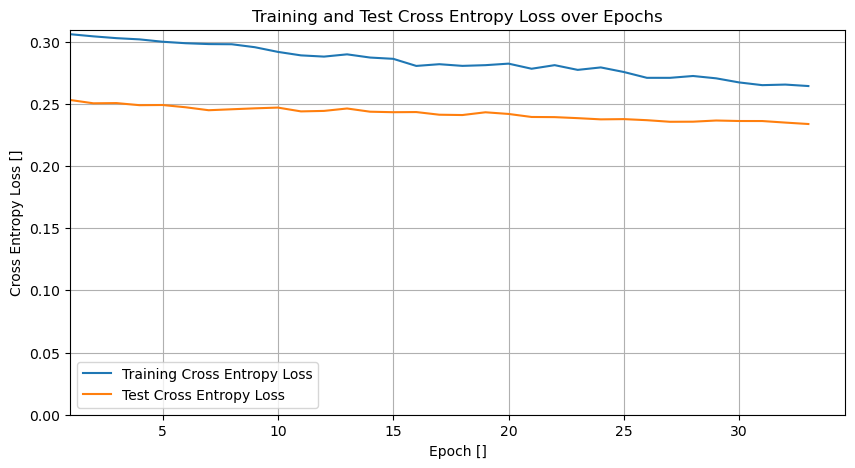

Epoch: 33
---------
Train Loss of [Batch 0/385]: 0.3876
Train Loss of [Batch 100/385]: 0.3169
Train Loss of [Batch 200/385]: 0.1847
Train Loss of [Batch 300/385]: 0.3364

Train loss: 0.26499 | Train accuracy: 91.85%
Train Class-wise Loss: tensor([0.2570, 0.2872], device='cuda:0')

Test loss: 0.23415 | Test accuracy: 88.86%
Test Class-wise Loss: tensor([0.3204, 0.3010], device='cuda:0')



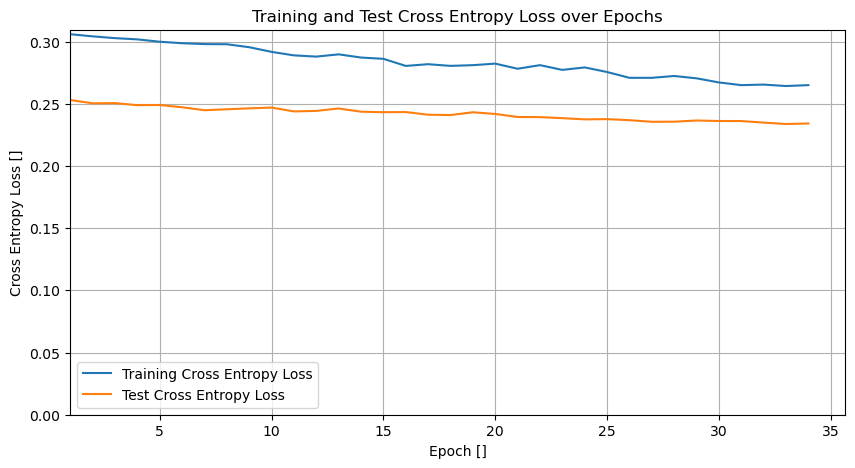

Epoch: 34
---------
Train Loss of [Batch 0/385]: 0.3462
Train Loss of [Batch 100/385]: 0.3042
Train Loss of [Batch 200/385]: 0.1875
Train Loss of [Batch 300/385]: 0.2903

Train loss: 0.26242 | Train accuracy: 91.88%
Train Class-wise Loss: tensor([0.2558, 0.2823], device='cuda:0')

Test loss: 0.23411 | Test accuracy: 89.63%
Test Class-wise Loss: tensor([0.2995, 0.3140], device='cuda:0')



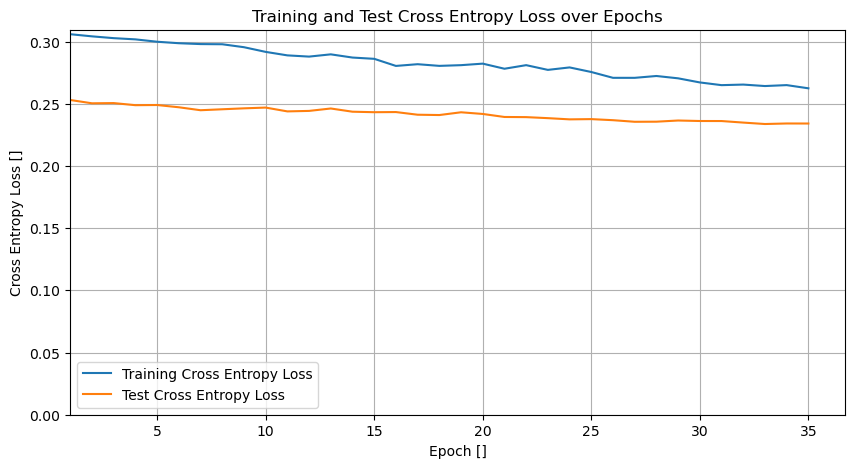

Epoch: 35
---------
Train Loss of [Batch 0/385]: 0.2133
Train Loss of [Batch 100/385]: 0.2969
Train Loss of [Batch 200/385]: 0.3945
Train Loss of [Batch 300/385]: 0.2052

Train loss: 0.26395 | Train accuracy: 92.04%
Train Class-wise Loss: tensor([0.2518, 0.2909], device='cuda:0')

Test loss: 0.23654 | Test accuracy: 90.07%
Test Class-wise Loss: tensor([0.2876, 0.3269], device='cuda:0')



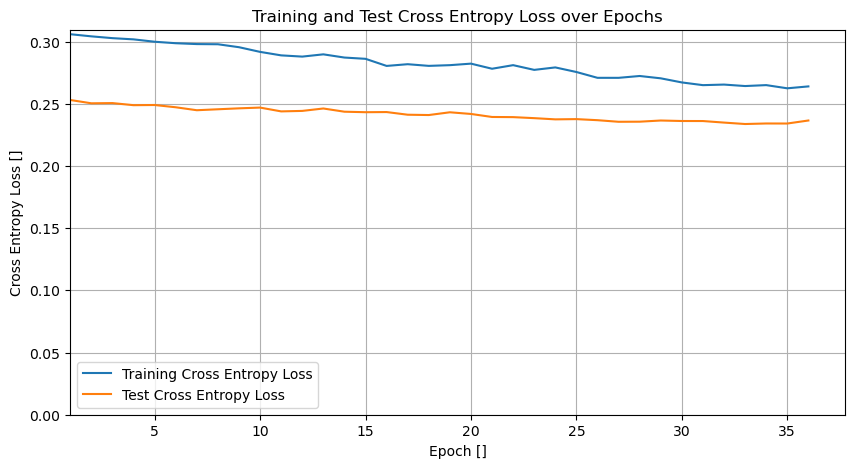

Epoch: 36
---------
Train Loss of [Batch 0/385]: 0.2126
Train Loss of [Batch 100/385]: 0.2480
Train Loss of [Batch 200/385]: 0.2314
Train Loss of [Batch 300/385]: 0.3502

Train loss: 0.26322 | Train accuracy: 92.00%
Train Class-wise Loss: tensor([0.2520, 0.2992], device='cuda:0')

Test loss: 0.23355 | Test accuracy: 89.03%
Test Class-wise Loss: tensor([0.3167, 0.2957], device='cuda:0')



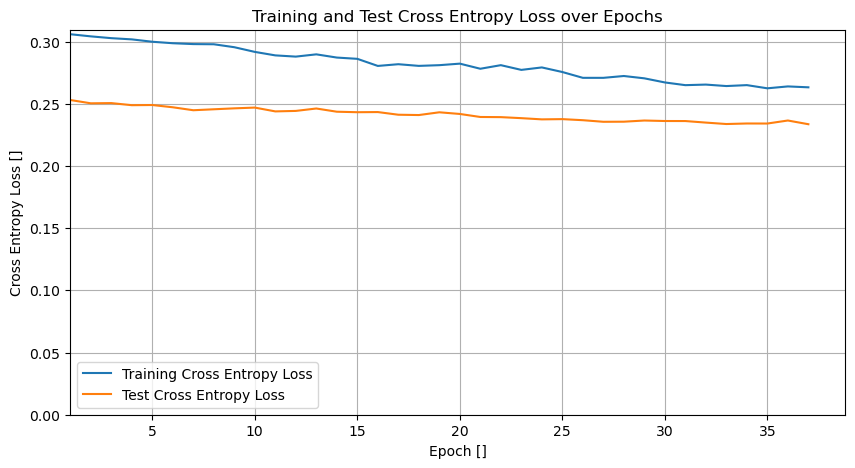

Epoch: 37
---------
Train Loss of [Batch 0/385]: 0.2648
Train Loss of [Batch 100/385]: 0.3096
Train Loss of [Batch 200/385]: 0.2005
Train Loss of [Batch 300/385]: 0.2558

Train loss: 0.25943 | Train accuracy: 92.06%
Train Class-wise Loss: tensor([0.2507, 0.2825], device='cuda:0')

Test loss: 0.23183 | Test accuracy: 89.31%
Test Class-wise Loss: tensor([0.3081, 0.3046], device='cuda:0')



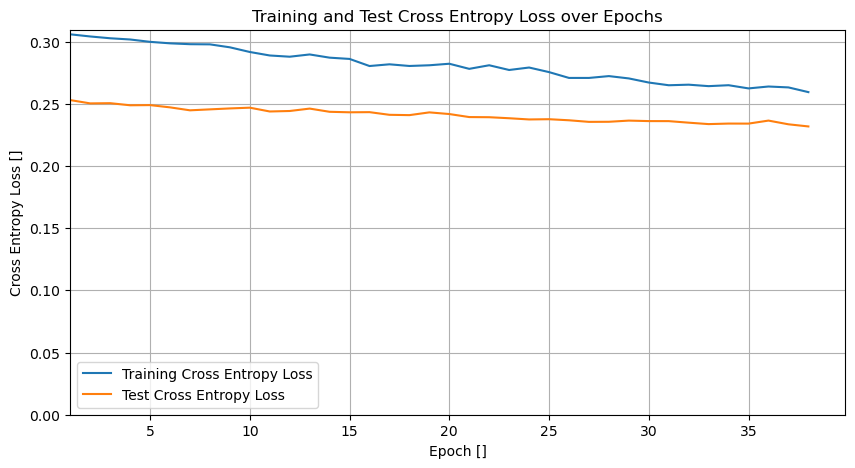

Epoch: 38
---------
Train Loss of [Batch 0/385]: 0.2043
Train Loss of [Batch 100/385]: 0.2442
Train Loss of [Batch 200/385]: 0.2503
Train Loss of [Batch 300/385]: 0.2514

Train loss: 0.25779 | Train accuracy: 91.87%
Train Class-wise Loss: tensor([0.2524, 0.2705], device='cuda:0')

Test loss: 0.23152 | Test accuracy: 88.78%
Test Class-wise Loss: tensor([0.3184, 0.2912], device='cuda:0')



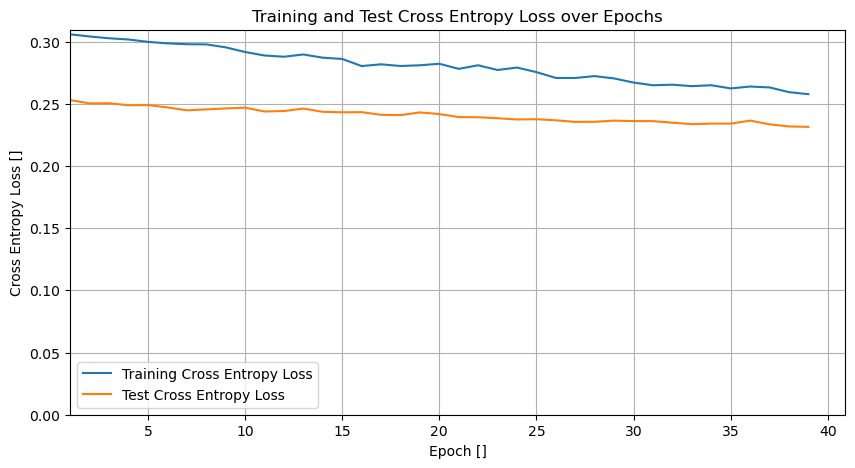

Epoch: 39
---------
Train Loss of [Batch 0/385]: 0.3541
Train Loss of [Batch 100/385]: 0.1365
Train Loss of [Batch 200/385]: 0.2060
Train Loss of [Batch 300/385]: 0.3903

Train loss: 0.26025 | Train accuracy: 91.95%
Train Class-wise Loss: tensor([0.2518, 0.2916], device='cuda:0')

Test loss: 0.23324 | Test accuracy: 89.13%
Test Class-wise Loss: tensor([0.3095, 0.3075], device='cuda:0')



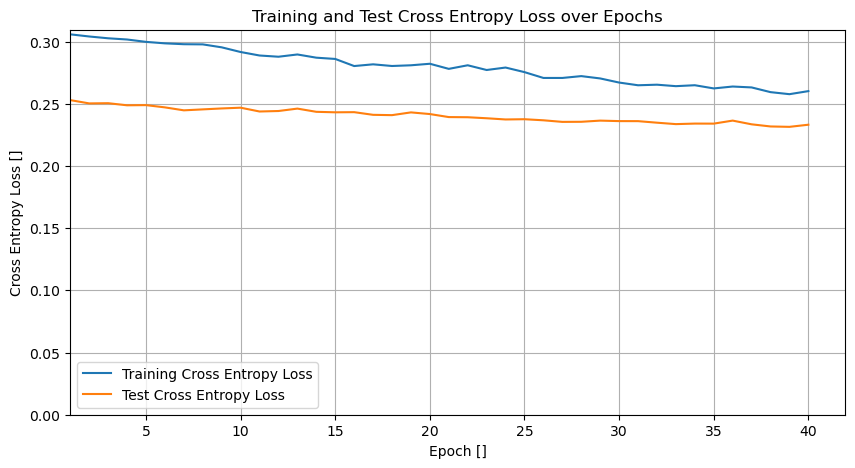

Epoch: 40
---------
Train Loss of [Batch 0/385]: 0.1423
Train Loss of [Batch 100/385]: 0.2640
Train Loss of [Batch 200/385]: 0.2145
Train Loss of [Batch 300/385]: 0.1834

Train loss: 0.25489 | Train accuracy: 92.17%
Train Class-wise Loss: tensor([0.2475, 0.2741], device='cuda:0')

Test loss: 0.23197 | Test accuracy: 88.54%
Test Class-wise Loss: tensor([0.3256, 0.2889], device='cuda:0')



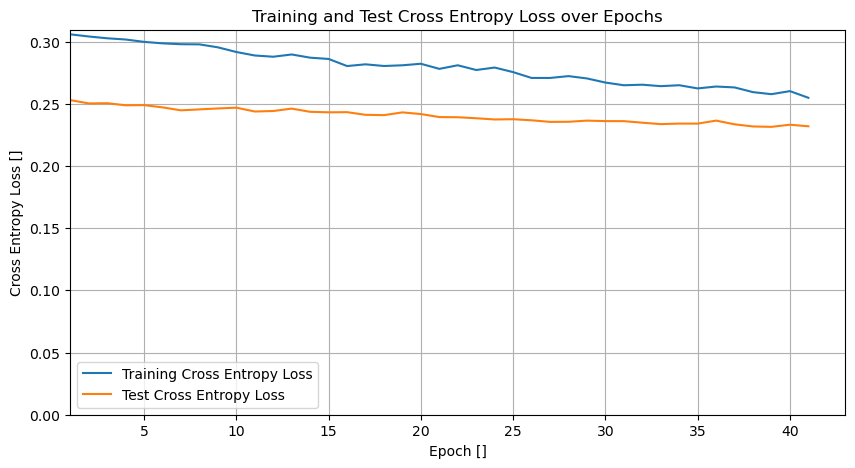

Epoch: 41
---------
Train Loss of [Batch 0/385]: 0.3523
Train Loss of [Batch 100/385]: 0.1959
Train Loss of [Batch 200/385]: 0.2144
Train Loss of [Batch 300/385]: 0.2944

Train loss: 0.25779 | Train accuracy: 92.25%
Train Class-wise Loss: tensor([0.2447, 0.2885], device='cuda:0')

Test loss: 0.23441 | Test accuracy: 90.25%
Test Class-wise Loss: tensor([0.2828, 0.3358], device='cuda:0')



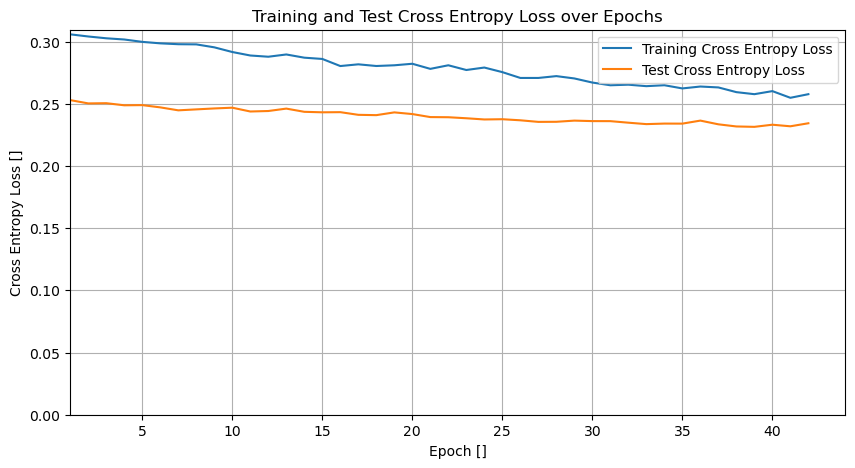

Epoch: 42
---------
Train Loss of [Batch 0/385]: 0.2099
Train Loss of [Batch 100/385]: 0.2731
Train Loss of [Batch 200/385]: 0.2177
Train Loss of [Batch 300/385]: 0.2326

Train loss: 0.25894 | Train accuracy: 92.01%
Train Class-wise Loss: tensor([0.2492, 0.2837], device='cuda:0')

Test loss: 0.23492 | Test accuracy: 89.75%
Test Class-wise Loss: tensor([0.2920, 0.3177], device='cuda:0')



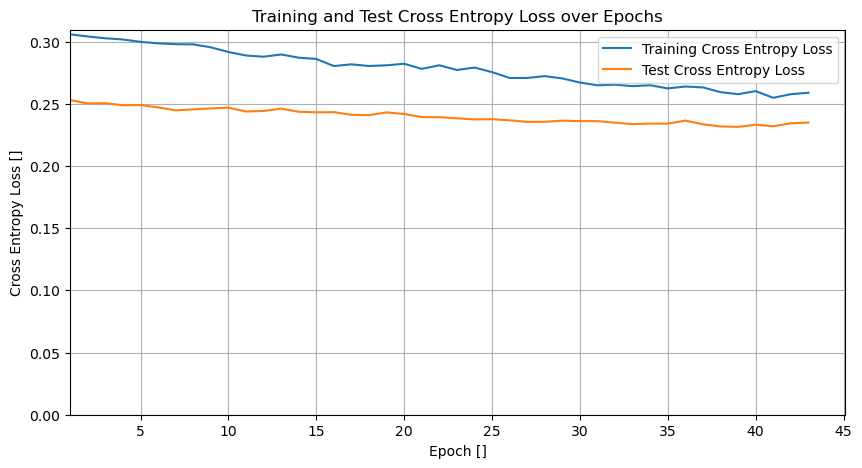

Epoch: 43
---------
Train Loss of [Batch 0/385]: 0.4210
Train Loss of [Batch 100/385]: 0.1725
Train Loss of [Batch 200/385]: 0.2464
Train Loss of [Batch 300/385]: 0.3376

Train loss: 0.25633 | Train accuracy: 92.00%
Train Class-wise Loss: tensor([0.2481, 0.2757], device='cuda:0')

Test loss: 0.23409 | Test accuracy: 89.89%
Test Class-wise Loss: tensor([0.2876, 0.3339], device='cuda:0')



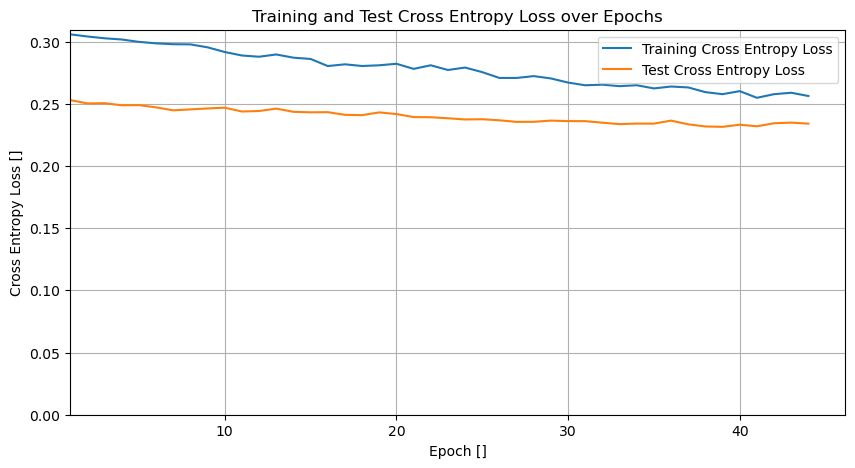

Epoch: 44
---------
Train Loss of [Batch 0/385]: 0.3265
Train Loss of [Batch 100/385]: 0.1539
Train Loss of [Batch 200/385]: 0.1704
Train Loss of [Batch 300/385]: 0.1920

Train loss: 0.25043 | Train accuracy: 92.04%
Train Class-wise Loss: tensor([0.2467, 0.2650], device='cuda:0')

Test loss: 0.23164 | Test accuracy: 89.23%
Test Class-wise Loss: tensor([0.3077, 0.3147], device='cuda:0')



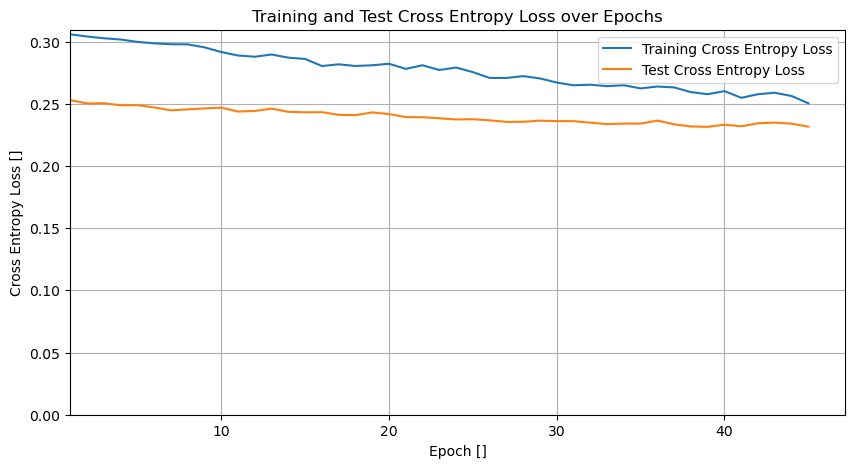

Epoch: 45
---------
Train Loss of [Batch 0/385]: 0.3107
Train Loss of [Batch 100/385]: 0.1773
Train Loss of [Batch 200/385]: 0.1709
Train Loss of [Batch 300/385]: 0.2472

Train loss: 0.24917 | Train accuracy: 92.20%
Train Class-wise Loss: tensor([0.2442, 0.2696], device='cuda:0')

Test loss: 0.23000 | Test accuracy: 88.95%
Test Class-wise Loss: tensor([0.3158, 0.2974], device='cuda:0')



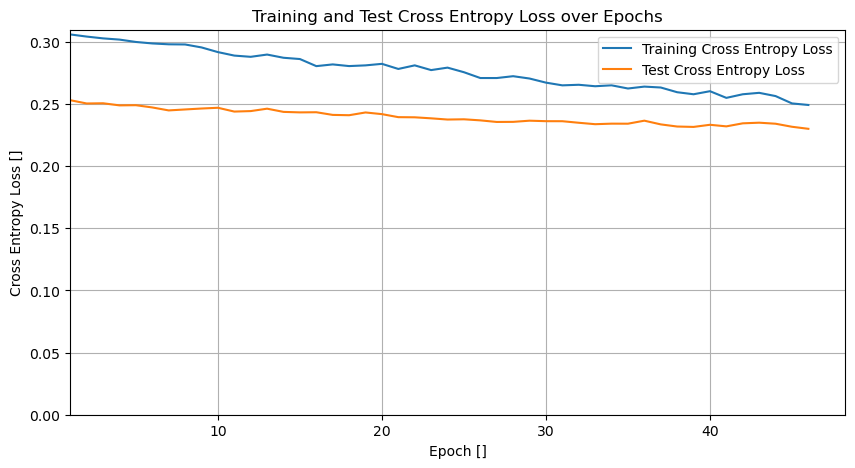

Epoch: 46
---------
Train Loss of [Batch 0/385]: 0.2520
Train Loss of [Batch 100/385]: 0.2447
Train Loss of [Batch 200/385]: 0.1938
Train Loss of [Batch 300/385]: 0.2439

Train loss: 0.25391 | Train accuracy: 92.16%
Train Class-wise Loss: tensor([0.2440, 0.2761], device='cuda:0')

Test loss: 0.23154 | Test accuracy: 89.05%
Test Class-wise Loss: tensor([0.3115, 0.3032], device='cuda:0')



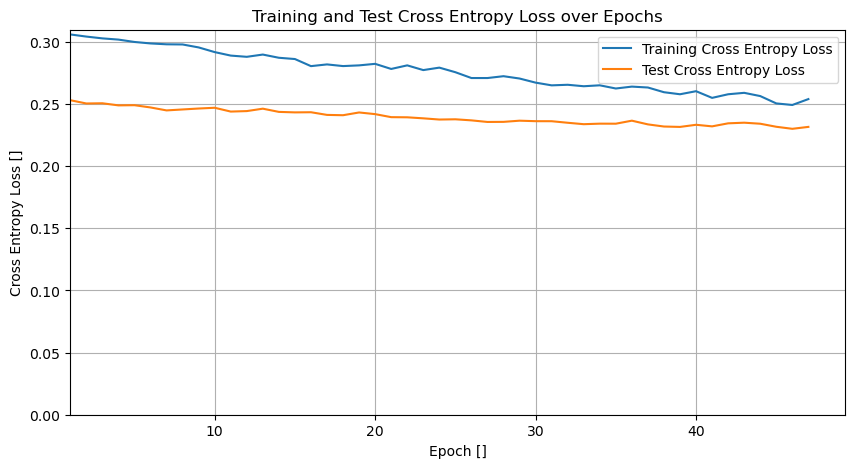

Epoch: 47
---------
Train Loss of [Batch 0/385]: 0.2440
Train Loss of [Batch 100/385]: 0.2234
Train Loss of [Batch 200/385]: 0.2450
Train Loss of [Batch 300/385]: 0.2652

Train loss: 0.25291 | Train accuracy: 92.23%
Train Class-wise Loss: tensor([0.2424, 0.2790], device='cuda:0')

Test loss: 0.23354 | Test accuracy: 90.29%
Test Class-wise Loss: tensor([0.2832, 0.3319], device='cuda:0')



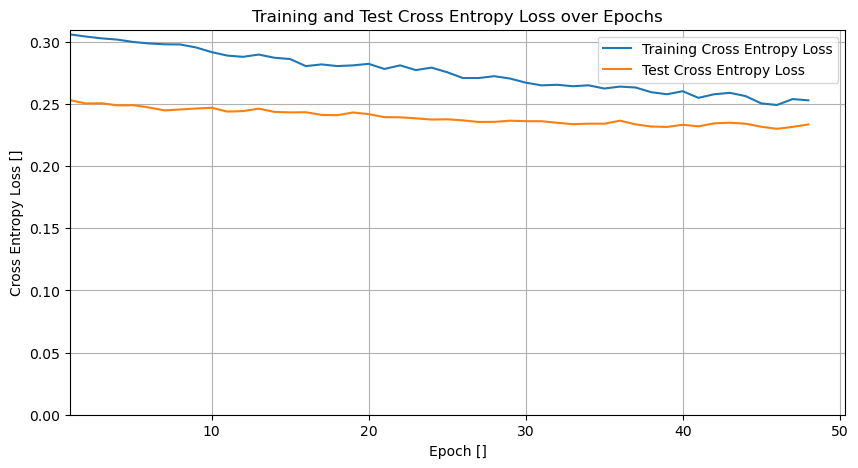

Epoch: 48
---------
Train Loss of [Batch 0/385]: 0.2045
Train Loss of [Batch 100/385]: 0.2027
Train Loss of [Batch 200/385]: 0.2240
Train Loss of [Batch 300/385]: 0.2250

Train loss: 0.24409 | Train accuracy: 92.31%
Train Class-wise Loss: tensor([0.2421, 0.2624], device='cuda:0')

Test loss: 0.23142 | Test accuracy: 89.29%
Test Class-wise Loss: tensor([0.3081, 0.3092], device='cuda:0')



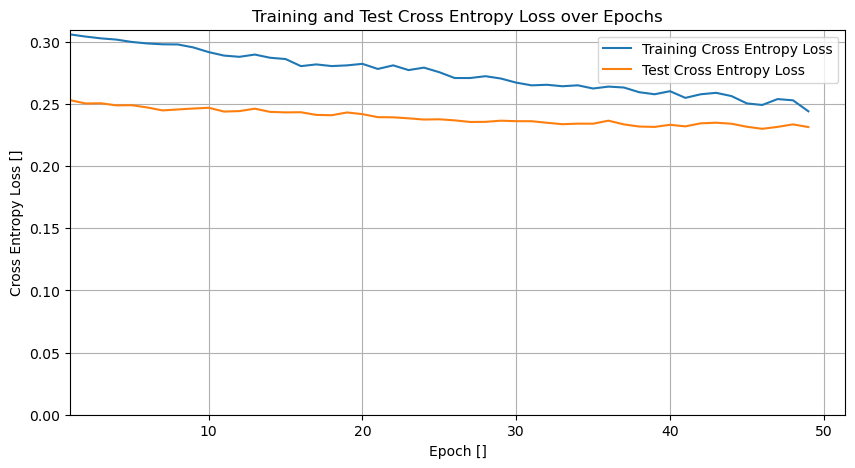

Epoch: 49
---------
Train Loss of [Batch 0/385]: 0.3015
Train Loss of [Batch 100/385]: 0.2458
Train Loss of [Batch 200/385]: 0.3714
Train Loss of [Batch 300/385]: 0.2227

Train loss: 0.25213 | Train accuracy: 92.18%
Train Class-wise Loss: tensor([0.2412, 0.2771], device='cuda:0')

Test loss: 0.23340 | Test accuracy: 89.87%
Test Class-wise Loss: tensor([0.2887, 0.3305], device='cuda:0')



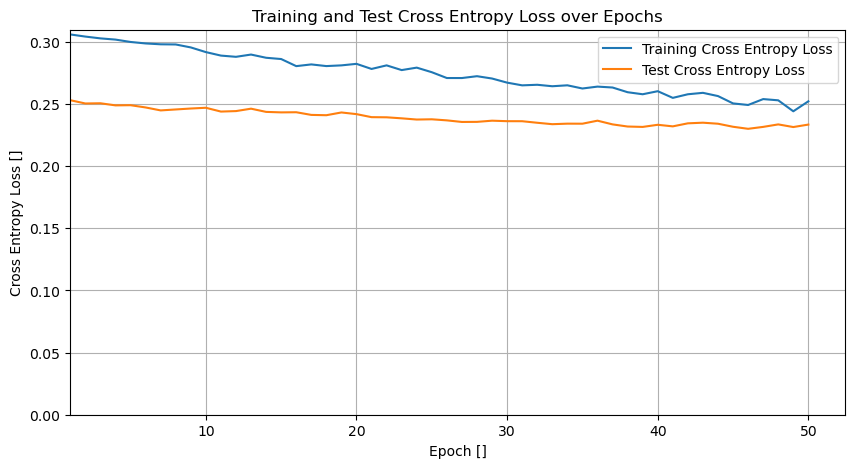

Train time on cuda: 11127.011 seconds


In [63]:
from tqdm.auto import tqdm

# Fix random seed for reproducibility
torch.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.cuda.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Learning rate:", configs_sc.HYPERPARAMETERS["learning_rate"])
print("Number of epochs:", configs_sc.HYPERPARAMETERS["epochs"])

# measure time with timing function
from timeit import default_timer as timer
start = timer()

# empty lists for storing of evaluation metrics
train_loss_progress = []
test_loss_progress = []
train_class_wise_losses = []
test_class_wise_losses = []

# epoch loop
for epoch in tqdm(range(configs_sc.HYPERPARAMETERS["epochs"])):
    print(f"Epoch: {epoch}\n---------") # print current epoch

    train_loss_epoch, train_class_wise_loss = train_utils.train_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_progress.append({"epoch": epoch + 1, "train loss": train_loss_epoch})
    train_class_wise_losses.append(train_class_wise_loss.cpu().numpy())  # change to numpy for easier plotting

    test_loss_epoch, test_class_wise_loss = train_utils.test_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_loss_progress.append({"epoch": epoch + 1, "test loss": test_loss_epoch})
    test_class_wise_losses.append(test_class_wise_loss.cpu().numpy())


    # Clear output and update plot
    epochs = [entry["epoch"] for entry in train_loss_progress]
    train_losses = [entry["train loss"] for entry in train_loss_progress]
    test_losses = [entry["test loss"].cpu().item() for entry in test_loss_progress]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Cross Entropy Loss")
    plt.plot(epochs, test_losses, label="Test Cross Entropy Loss")
    plt.xlabel("Epoch []")
    plt.ylabel("Cross Entropy Loss []")
    plt.title("Training and Test Cross Entropy Loss over Epochs")
    plt.xlim(left=1) # Force x-axis to start at epoch 1
    plt.ylim(bottom=0) # Force y-axis to start at 0
    plt.legend()
    plt.grid(True)
    plt.show()



end = timer()
train_utils.print_train_time(start, end, device)

**VISUALIZE!**

In [ ]:
# Plot train class-wise loss of a specific epoch
# ADJUSTABLE!
# try_epoch = 2
# visualization_utils.plot_classwise_loss(try_epoch, train_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

In [ ]:
# Plot test class-wise loss of a specific epoch
# visualization_utils.plot_classwise_loss(try_epoch, test_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

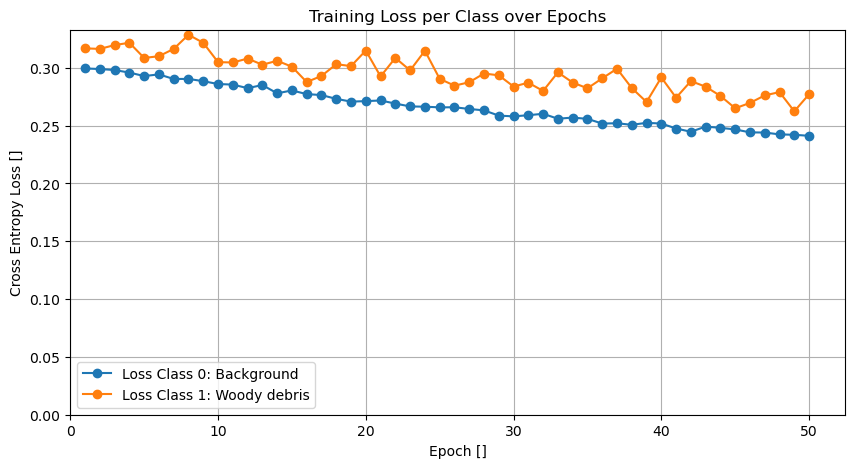

In [64]:
# Plot the train loss curves per class

# Create a list of epoch numbers based on the number of entries in train_class_wise_losses
epochs = list(range(1, len(train_class_wise_losses) + 1))

# Extract the loss for class 0 and class 1 for each epoch.
# Here, we assume that each entry in train_class_wise_losses is a tuple or array like [loss_class0, loss_class1, ...].
class0_losses = [losses[0] for losses in train_class_wise_losses]
class1_losses = [losses[1] for losses in train_class_wise_losses]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, class0_losses, marker='o', linestyle='-', label="Loss Class 0: Background")
plt.plot(epochs, class1_losses, marker='o', linestyle='-', label="Loss Class 1: Woody debris")
plt.xlabel("Epoch []")                          # Set the x-axis label
plt.ylabel("Cross Entropy Loss []")                           # Set the y-axis label
plt.title("Training Loss per Class over Epochs")  # Set the plot title
plt.xlim(left=0)                              # Force x-axis to start at epoch 0
plt.ylim(bottom=0)                            # Force y-axis to start at 0
plt.legend()                                 # Display the legend
plt.grid(True)                               # Enable grid for better readability
plt.show()                                   # Display the plot

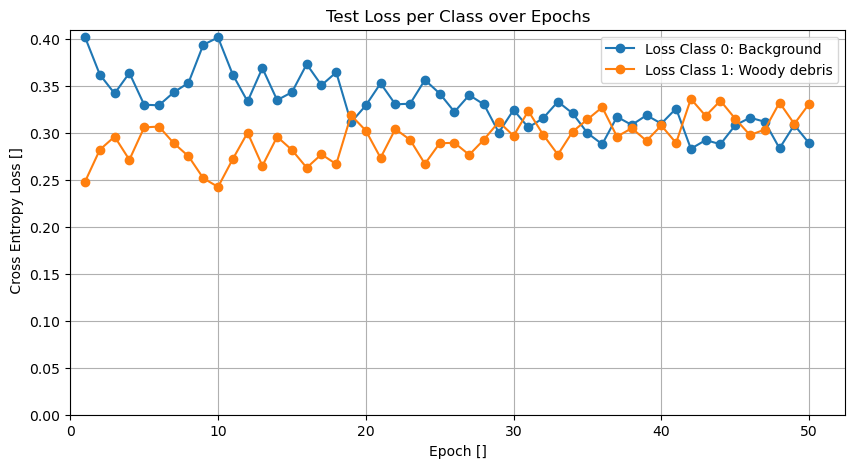

In [65]:
# Plot the test loss curves per class

# Create a list of epoch numbers based on the number of entries in train_class_wise_losses
epochs = list(range(1, len(test_class_wise_losses) + 1))

# Extract the loss for class 0 and class 1 for each epoch.
# Here, we assume that each entry in train_class_wise_losses is a tuple or array like [loss_class0, loss_class1, ...].
class0_losses = [losses[0] for losses in test_class_wise_losses]
class1_losses = [losses[1] for losses in test_class_wise_losses]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, class0_losses, marker='o', linestyle='-', label="Loss Class 0: Background")
plt.plot(epochs, class1_losses, marker='o', linestyle='-', label="Loss Class 1: Woody debris")
plt.xlabel("Epoch []")                          # Set the x-axis label
plt.ylabel(" Cross Entropy Loss []")                           # Set the y-axis label
plt.title("Test Loss per Class over Epochs")  # Set the plot title
plt.xlim(left=0)                              # Force x-axis to start at epoch 0
plt.ylim(bottom=0)                            # Force y-axis to start at 0
plt.legend()                                 # Display the legend
plt.grid(True)                               # Enable grid for better readability
plt.show()                                   # Display the plot

## 5. Save and load trained model

1. Create individual name of the trained

In [66]:
# Create INDIVIDUAL model name and add to corresponding path

# counter for model version
counter = 1

# function for generating initial model name
def generate_model_name(base_name, epochs, counter):
    return f"{base_name}_{epochs}_{counter}.pth"

base_name = "unet_model_2class_dataaugmentation_100"

# generate initial name and path
MODEL_NAME = generate_model_name(base_name, configs_sc.HYPERPARAMETERS["epochs"], counter)
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

# check if there is already a model saved with the same name -> if so: increase the counter
while os.path.exists(save_model_path):
    print(f"Warning: File with name {MODEL_NAME} already exists. Increase the counter...")
    counter += 1
    MODEL_NAME = generate_model_name(base_name, configs_sc.HYPERPARAMETERS["epochs"], counter)
    save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

2. Save the models state dict

In [67]:
# Save the models state dict
print(f"Saving model to: {save_model_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=save_model_path)

Saving model to: /home/sc.uni-leipzig.de/rf37uqip/MoSE/saved_models/unet_model_2class_dataaugmentation_100_50_1.pth


**3. Load the model**

In [68]:
# Load the model

#######
MODEL_NAME = "unet_model_2class_dataaugmentation_100_50_1.pth" # ---------> ADJUSTABLE!
#######
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

# Create a new instance of the model (same class as our saved state_dict())
loaded_model = model_utils.model_0.to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=save_model_path, weights_only=True))

# Send model to GPU
loaded_model = loaded_model.to(device)

## 6. Evaluate trained model

Make predictions for the entire test data set with the trained model and display the results in a confusion matrix.

### 6.1 Confusion Matrix, Accuracies and F1-Scores
Confusion Matrix for entire test data set!

Test accuracy: 89.87%



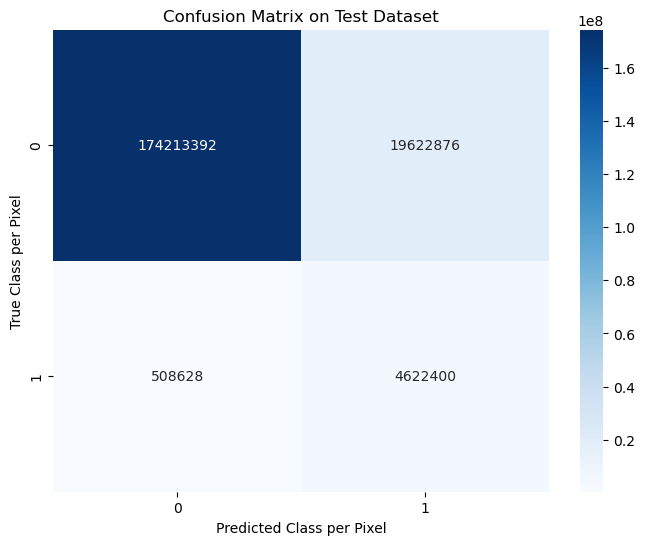

Class-wise evaluation metrics:
   Class  Precision  Recall  F1-Score
0      0     0.9971  0.8988    0.9454
1      1     0.1907  0.9009    0.3147

Macro Precision: 0.5939
Macro Recall: 0.8998
Macro F1-Score: 0.63


In [69]:
# predictions for entire test data set
evaluation_utils.evaluate_model_with_testdata(loaded_model, test_loader, accuracy_fn, configs_sc.HYPERPARAMETERS["num_classes"], device, F1_analysis = True)

Confusion Matrix, Accuracies and F1-Scores for a part of the test data set!

In [70]:
# predictions for a part of the test data set
# from torch.utils.data import Subset

# # use only __ patch(es) of the test data set
# subset_indices = range(100)  # indices of sample test data set
# subset_test_data = Subset(test_loader.dataset, subset_indices)


# # create subset of test_loader
# subset_test_loader = DataLoader(subset_test_data, batch_size=test_loader.batch_size, shuffle=False)

# evaluation_utils.evaluate_model_with_testdata(
#     loaded_model, subset_test_loader, accuracy_fn, 
#     configs_sc.HYPERPARAMETERS["num_classes"], device, 
#     F1_analysis = True)

### 6.2 Visual Evaluation

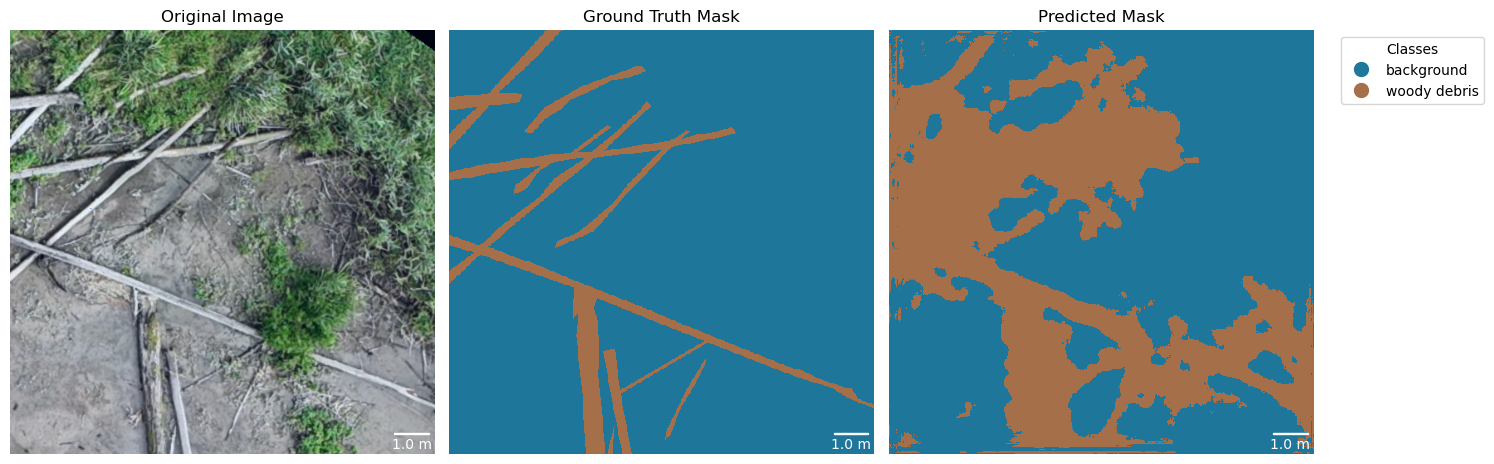

In [71]:
##################### Choose single patch by section and id
SECTION = "A04" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 209 # -------------------->> ADJUSTABLE
#####################
# 1432

# Name of chosen patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"

visualization_utils.visualize_prediction(test_patch_name, test_loader, loaded_model, device, reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"])

## Citing

In [ ]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }